# Convolutional Neural Networks for Computer Vision
_Example of the use of CNNs for object detection_

---

Object detection is a task in computer vision that involves identifying the presence, location, and type of one or more objects in a given photograph. It is a challenging problem that involves building upon methods for object recognition (_e.g._, where are they), object localization (_e.g._, what are their extent), and object classification (_e.g._, what are they).

In recent years, deep learning techniques are achieving state-of-the-art results for object detection, such as on standard benchmark datasets and in computer vision competitions. Notable is the “You Only Look Once”, or YOLO, a family of Convolutional Neural Networks that achieve near state-of-the-art results with a single end-to-end model that can perform object detection in real-time.

In this lab, we will first focus on the simpler problem of object localization. The localization problem considers that only one object is present on the image, while the detection problem tries to determine all the objects present on the image. Then, we will implement a simplified version of YOLO

<!-- In this tutorial, we will put into practice some of the methods discussed in class to locate objects in an image. -->

---

In [1]:
import PIL
from PIL import Image
import os, sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.utils as ku

2022-10-17 10:56:55.522739: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


---
# PART I: Object Localization

As said, in this section, we will focus on the simpler problem of locating a single object per image, _i.e._, locating the object associated with the dominant class of a classification algorithm. 

As we have seen during the course, in both localization and detection, we try to simultaneously determine an object's position and class in the form of a bounding box. The bounding box is encoded by its width $b_w$, its height $b_h$, and its center whose coordinates are given by the pair $(b_x, b_y)$. 

<center> <img src="https://drive.google.com/uc?id=1_jHHv6ZDe-3Xz25jIZ6o177laBEfmMRR" style="width:500;height:300px;"></center>
<caption><center><b>Figure 1:</b> Bounding box model used for localization</center></caption>

## Data exploration

To begin, download the database images. You will find all the data at the following link: [Wildlife dataset](https://drive.google.com/drive/folders/16EYaEPi4zfq96XWEtkqW7m2gVdpXORu6?usp=sharing). _For the rest of the tutorial, we will need this data to be in a `wildlife` folder, in the current folder._

The database has 4 classes, for the following 4 animals: buffalo, elephant, rhinoceros and zebra. It contains **376** images of each of the 4 classes.

<center> <img src="https://drive.google.com/uc?id=1sej2InBiQDEmpk2RA7S2dLRsJvF_UszE" width=200>
<img src="https://drive.google.com/uc?id=1K8cO4plzVIXO1MC4mkRcFIFjgspHtOIm" width=200>
<img src="https://drive.google.com/uc?id=15pkHpPW_VR1joOyPryS1pavOTqmoNR88" width=200>
<img src="https://drive.google.com/uc?id=19zHZn-A_j8Sx0G3V2SwR_YNKF0dGI1NA" width=200></center>
<caption><center><b>Figure 2:</b> Examples of images from the database</center></caption>

##### <span style="color:purple">**Todo:** Display an image of the training dataset</span>

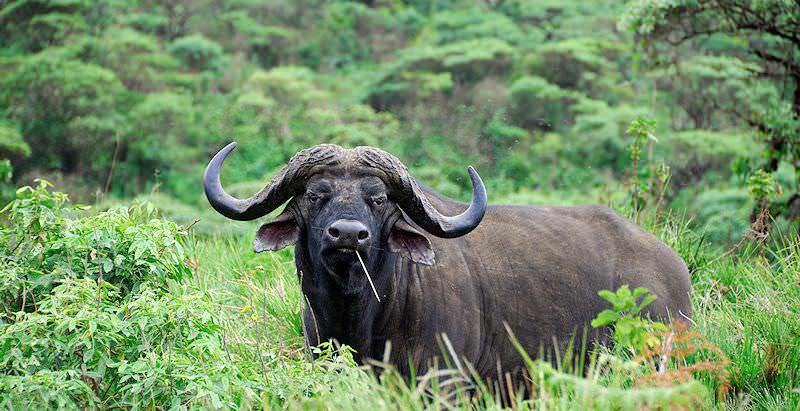

In [4]:
data = 'wildlife'
img = kpi.load_img(data+'/buffalo/001.jpg')  # this is a PIL image
img

In [5]:
# %load solutions/disp_img.py

##### <span style="color:purple">**Question:** What is the format used in the database to encode the labels?</span>

A chaque image est associé un fichier '[num_image].txt' qui comporte autant de lignes que danimaux ans la photo, et 5 colonnes, la première correspond au numéro de la classe (`0:buffalo`, `1:elephant`, `2:rhino`, `3:zebra`)

The function below will load the data and format it for classification. Some remarks about this function
* To be able to use our images in a reasonable amount of time, we will have to start by resizing them.
* We want the label to be of the form seen during the course, _i.e._, presence + bounding box + classes
* If there are several objects in the same image, we will consider only the object whose bounding box takes up the largest area in the image.




##### <span style="color:purple">**Question:** We consider square images, denoted $x$, of size $s$ and we want to store them in a `numpy`array.</span>
1. <span style="color:purple">How big should the array for the image $x$ be?</span>

Size for an image $x$:

<span style="color:teal ">[Solution]</span>

<!-- $x$ being a square image of size $s$, in color (3 channels), it is of size $(s,s,3)$. -->

2. <span style="color:purple">We also want to store the labels, denoted $y$, in a `numpy` array. What size should this array be?</span>

Size for a label $y$: presence+bounding_box+classes = 1+4+4 = 9

<span style="color:teal ">[Solution]</span>

<!-- $y$ is a vector that must contain "presence" + "bounding box" + "classes". It is therefore size $9 = 1+4+4$. -->

In [6]:
pip install np_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow.keras.utils as ku

# Total number of images
DATASET_SIZE = 376*4  ### TO BE COMPLETED ###

# Here we choose the dimension in which we will resize the images:
# 64x64 is a rather small size but it will allow us to have faster experiments
# 128x128 or 256x256 would give better results but at the cost of several hours of training
IMAGE_SIZE = 64

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [8]:
def load_data_localization(image_size):
    # Path to the database
    ds_path = "./wildlife/"
    # Paths to the data of the 4 different classes
    paths = [ds_path + "buffalo/", ds_path + "elephant/", ds_path + "rhino/", ds_path + "zebra/"]
    # Index for adding data to the x and y variables 
    i = 0
    # Preparation of data structures for x and y
    x = np.zeros((DATASET_SIZE, image_size, image_size, 3)) ### TO BE COMPLETED ### 
    y = np.empty((DATASET_SIZE, 9)) ### TO BE COMPLETED ### 

    # Browse paths of each class
    for path in paths:

        # Browse the (sorted) files in the directory
        dirs = os.listdir(path)
        dirs.sort()

        for item in dirs:
            if os.path.isfile(path + item):
                # Extracting the file extension 
                extension =item.split(".")[1]

            if extension == "jpg" or extension == "JPG":
                # Image : we will fill the variable x
                # Reading the image
                img = Image.open(path + item)
                # Image scaling
                img = img.resize((image_size,image_size), Image.ANTIALIAS)
                # Filling the variable x
                x[i] = np.asarray(img)

            elif extension == "txt":
                # Text file: bounding box coordinates to fill y
                labels = open(path + item, "r")
                # Retrieving of lines from the text file
                labels = labels.read().split('\n')
                # If the last line is empty, delete it 
                if labels[-1] == "":
                    del labels[-1]

                # Maximum area bounding box index
                j_max = 0
                if len(labels) > 1:
                    area_max = 0 # Bounding box area of maximum area
                    # Browse bounding boxes for objects in the image
                    for j in range(len(labels)):
                        # Compute the area of the current bounding box
                        area = float(labels[j].split()[3])*float(labels[j].split()[4]) ### TO BE COMPLETED ###
                        ### Notice that labels[j].split()[k] allows access to the k-th element of the label j ###
                        # Update the maximum area bounding box, if necessary
                        if area > area_max:
                            area_max = area
                            j_max = j    

                # An object is present on the image (presence = 1)
                presence = np.array([1], dtype="i")
                # "One-hot vector " to represent the class probabilities
                classes = ku.to_categorical(labels[j_max].split()[0], num_classes=4)###
                # Coordinates of the maximum area bounding box
                coordinates = np.array(labels[j_max].split()[1:], dtype="f")
                # Filling the variable y
                y[i, 0] = presence
                y[i, 1:5] = coordinates
                y[i, 5:] = classes

                i = i + 1
            else:
                print("extension found: ", extension)

    return x, y

In [9]:
# %load solutions/load_data_localization.py

In [10]:
x,y = load_data_localization(IMAGE_SIZE)

We separate our data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# To improve the training, we can center-reduce the coordinates of the bounding boxes
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[:,1:5] = (y_train[:,1:5] - y_mean[1:5])/y_std[1:5]
y_val[:,1:5] = (y_val[:,1:5] - y_mean[1:5])/y_std[1:5]

# And normalize the color values
x_train = x_train/255
x_val = x_val/255

The following function allows to visualize the objects located on the images, _i.e._ on each image the selected bounding box, in a suitable color, and its associated class.

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [12]:
# If only x and y are indicated, an image number is randomly drawn and the y label associated with the image is displayed
# If a 2nd y, named y_pred, is indicated, then the two labels are displayed side by side, so that they can be compared
# Finally, you can also indicate the id of the image you wish to view.

def print_data_localization(x, y, y_pred=[], id=None, image_size=IMAGE_SIZE):
    if id==None:
        # Random drawing of an image in the database
        num_img = np.random.randint(x.shape[0]-1)
    else:
        num_img = id

    img = x[num_img]
    lab = y[num_img]

    colors = ["blue", "yellow", "red", "orange"] # Different colors for different classes
    classes = ["Buffalo", "Elephant", "Rhino", "Zebra"]

    if np.any(y_pred):
        plt.subplot(1, 2, 1)

    # Image display
    plt.imshow(img)
    ### TO BE COMPLETED ###
    # Determination of the class
    class_id = np.argmax(lab[5:]) ### TO BE COMPLETED ###

    # Determining the coordinates of the bounding box in the image frame
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Determination of the extrema of the bounding box, namely the minimum and maximum x/y value for each box
    p_x = [ax-width/2, ax+width/2] ### TO BE COMPLETED ###
    p_y = [ay-height/2, ay+height/2] ### TO BE COMPLETED ###
    # Display the bounding box in the right color
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Ground truth : Image {} - {}".format(num_img, classes[class_id]))

    if np.any(y_pred):
        plt.subplot(1, 2, 2)
        # Image display
        plt.imshow(img) ### TO BE COMPLETED ###
        lab = y_pred[num_img]
        # Determination of the class
        class_id =   np.argmax(lab[5:])
        
        # Determining the coordinates of the bounding box in the image frame
        ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
        ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
        width = (lab[3]*y_std[3] + y_mean[3]) * image_size
        height = (lab[4]*y_std[4] + y_mean[4]) * image_size
        #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
        # Determination of the extrema of the bounding box
        p_x = [ax-width/2, ax+width/2] ### TO BE COMPLETED ###
        p_y = [ay-height/2, ay+height/2] ### TO BE COMPLETED ###
        # Display the bounding box in the right color
        plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
        plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
        plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
        plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
        plt.title("Prediction: Image {} - {}".format(num_img, classes[class_id]))

    plt.show()

In [13]:
# %load solutions/print_data_localization.py

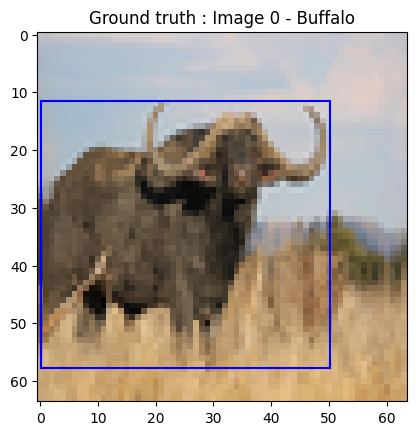

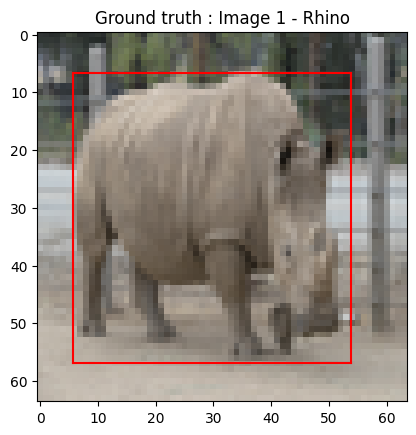

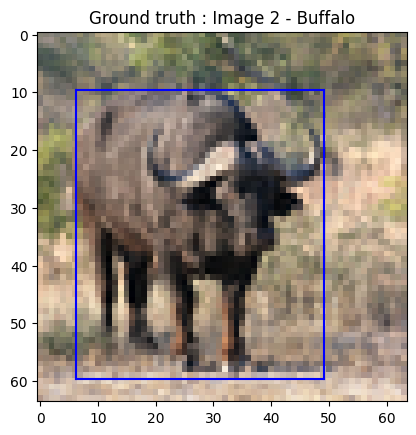

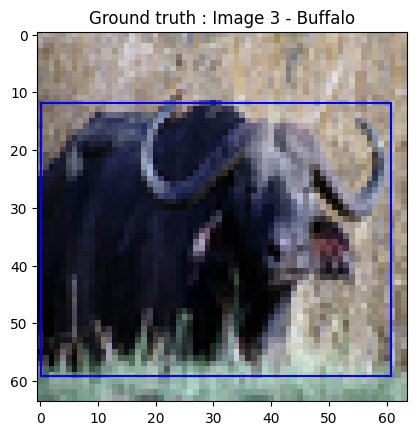

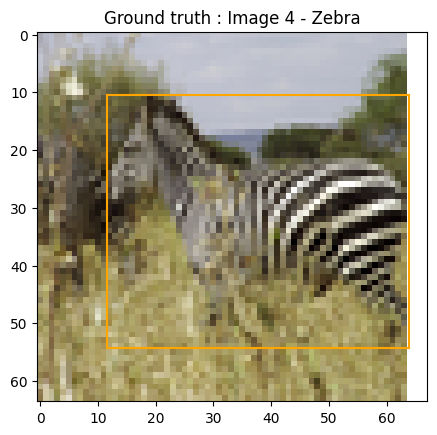

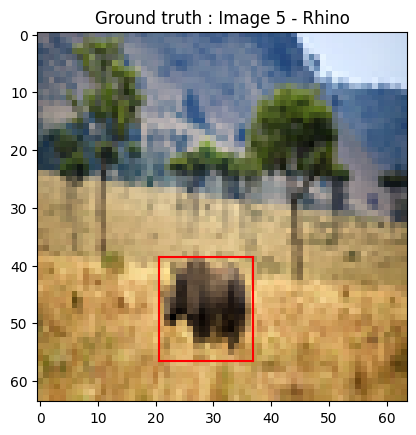

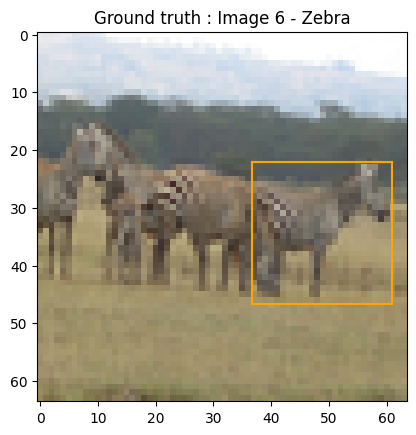

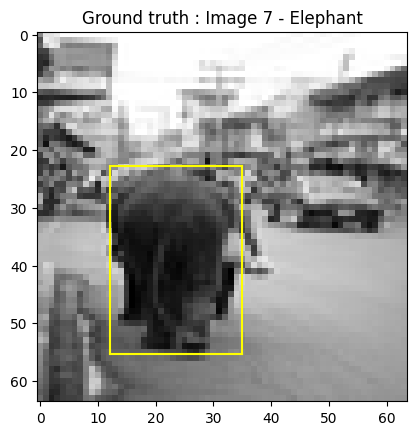

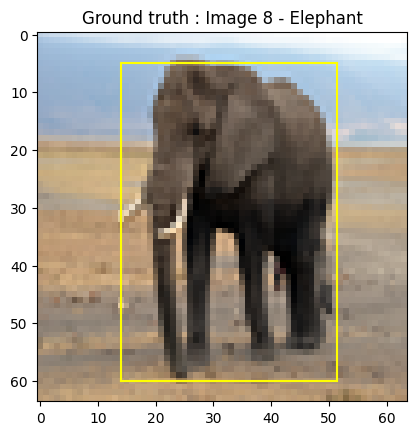

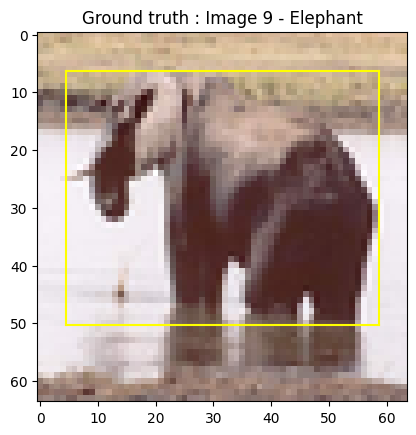

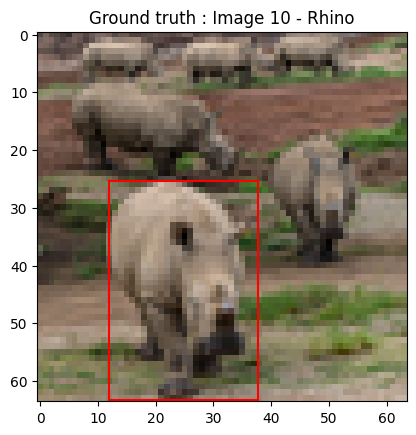

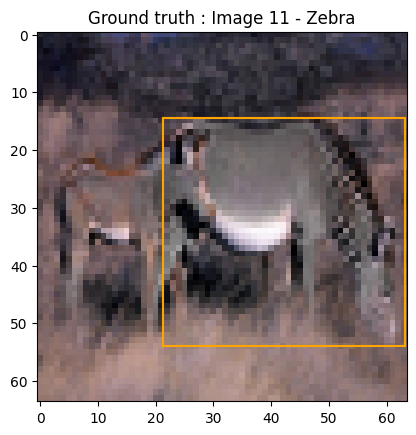

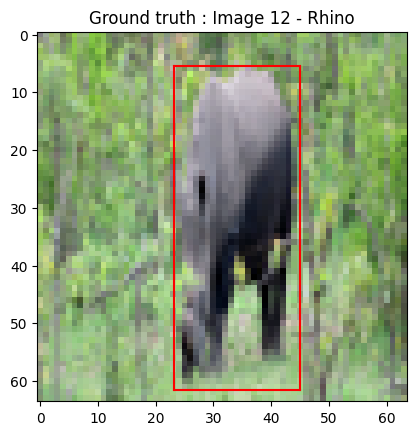

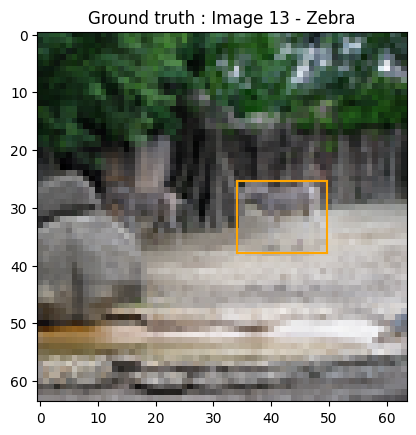

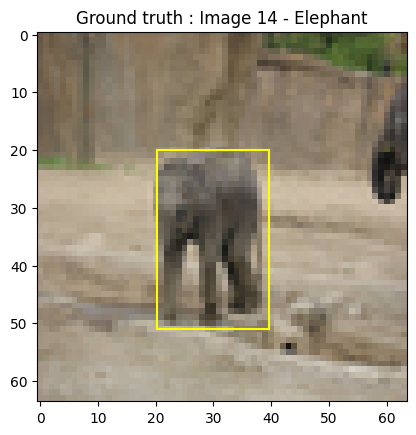

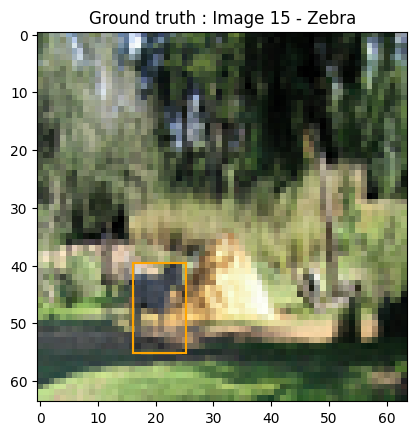

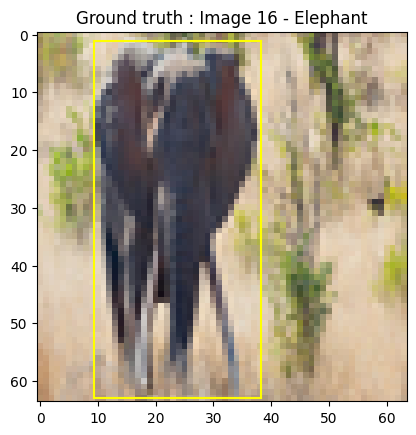

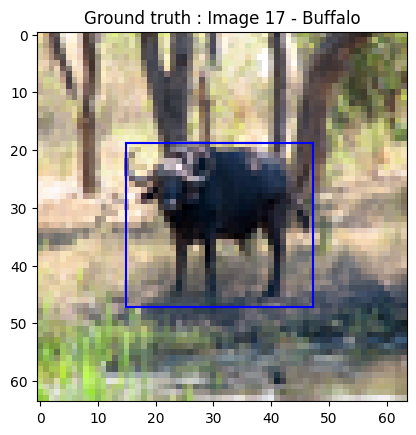

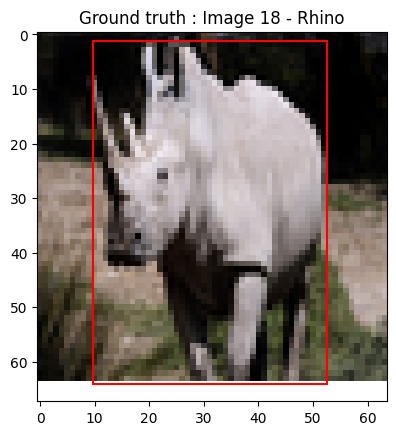

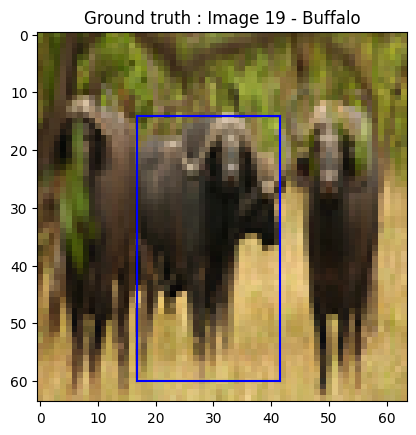

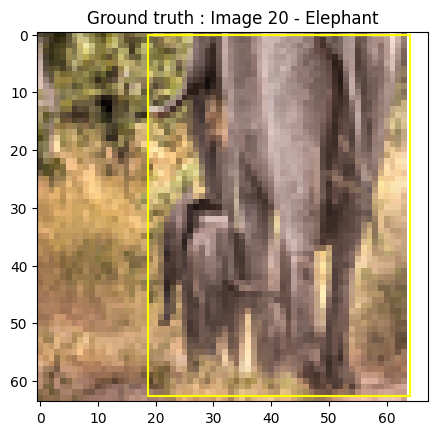

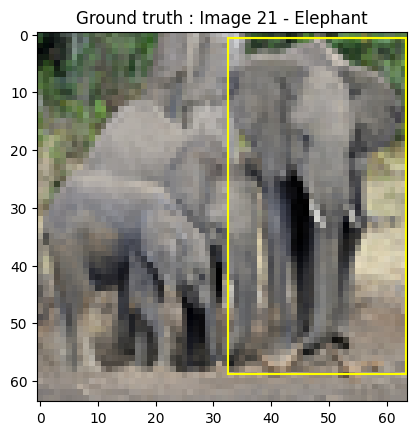

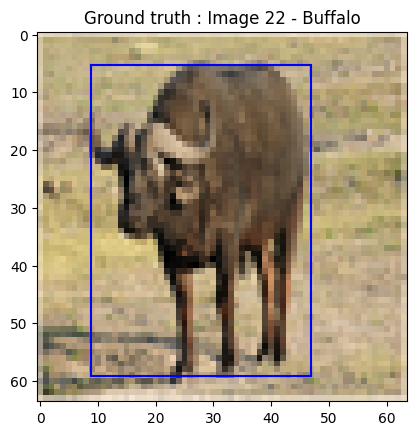

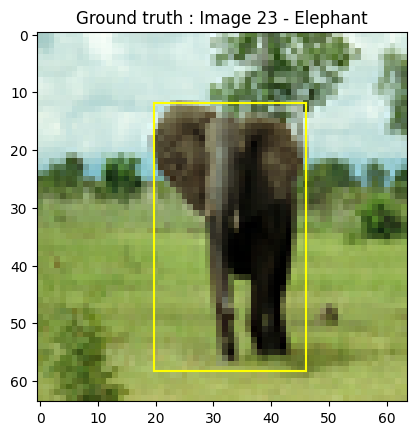

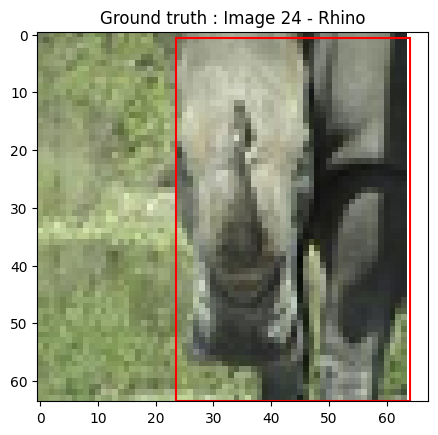

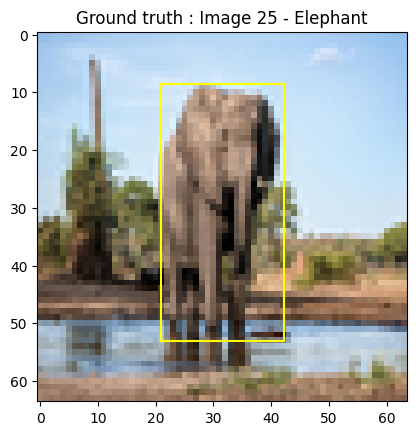

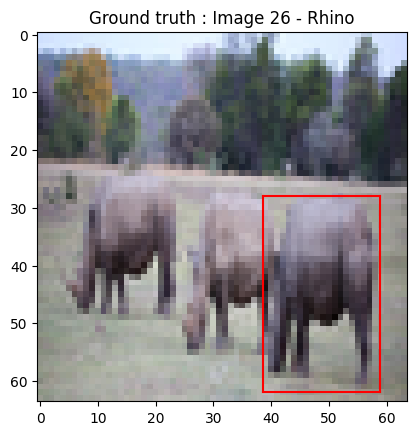

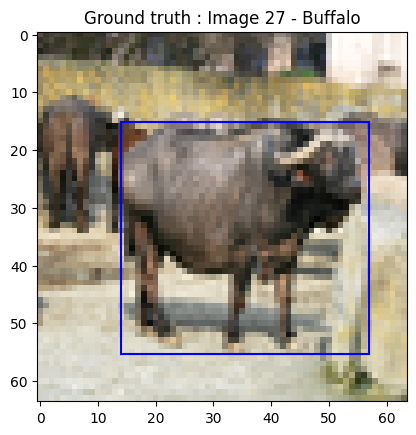

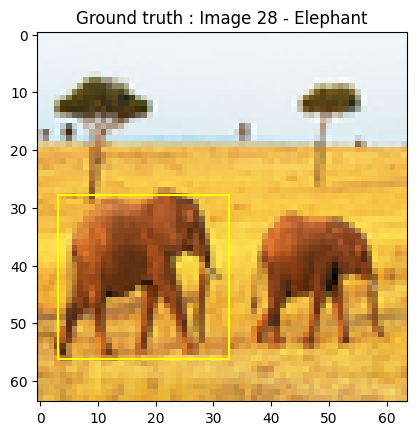

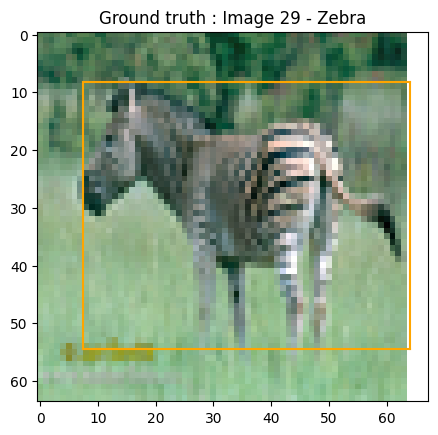

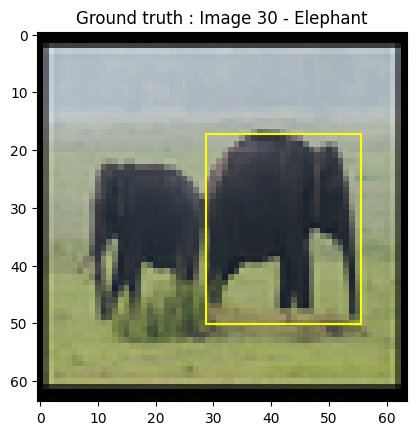

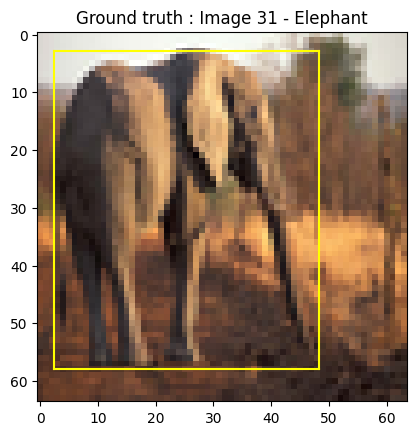

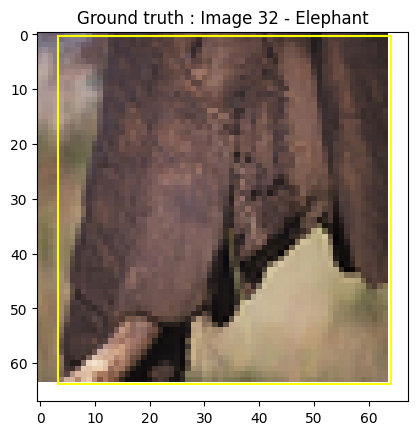

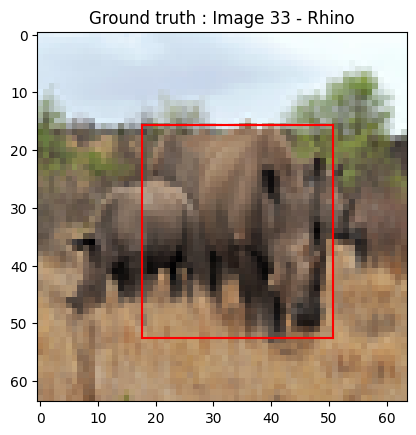

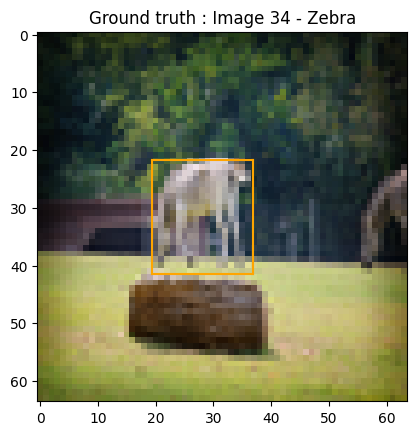

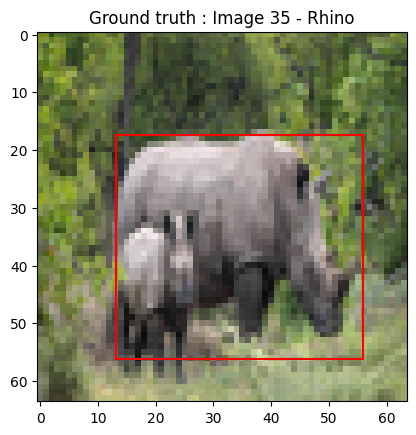

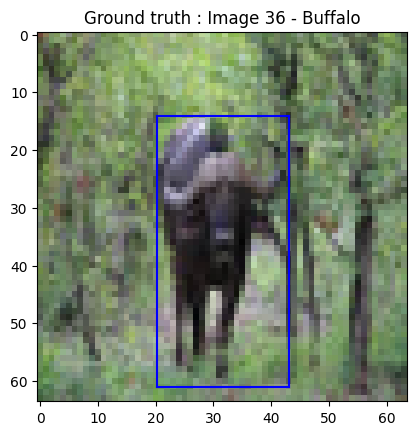

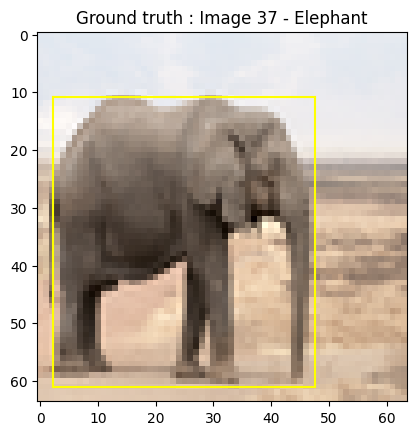

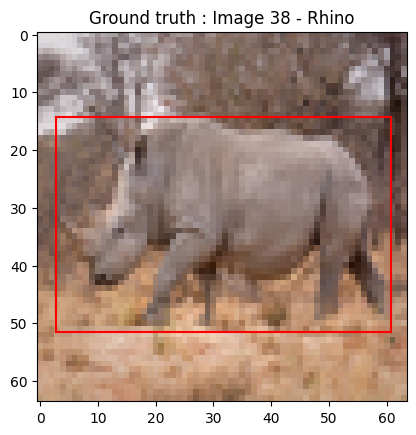

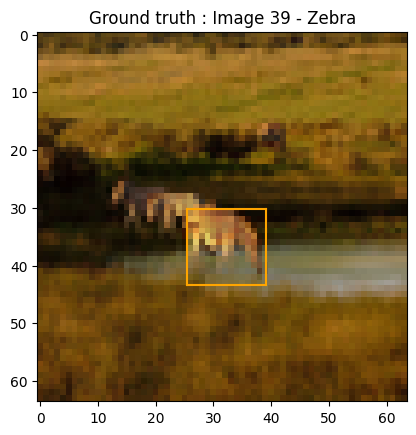

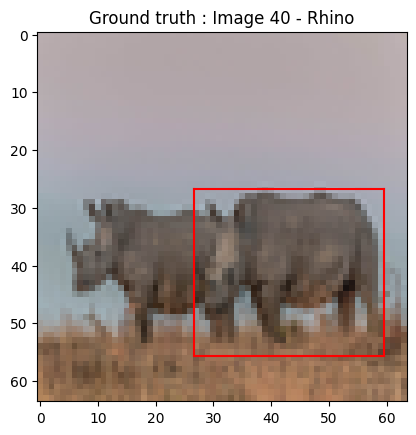

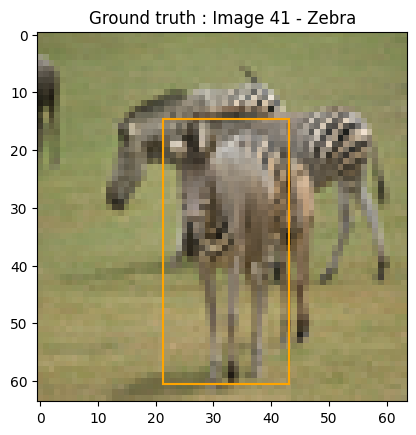

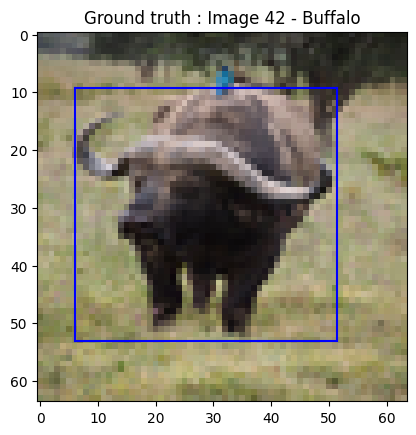

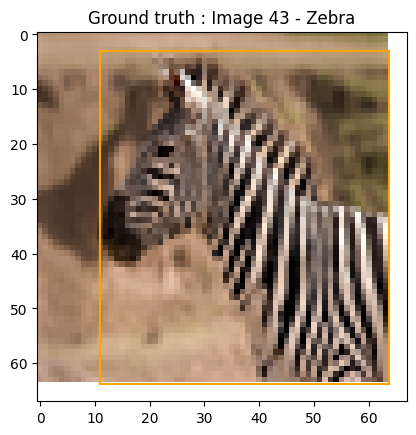

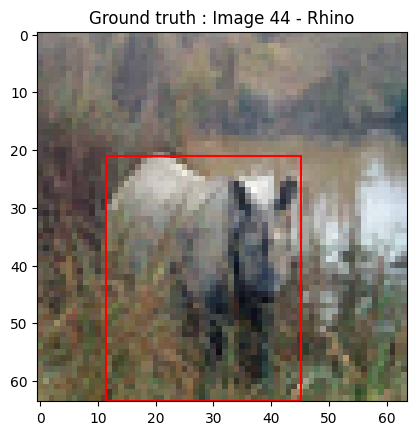

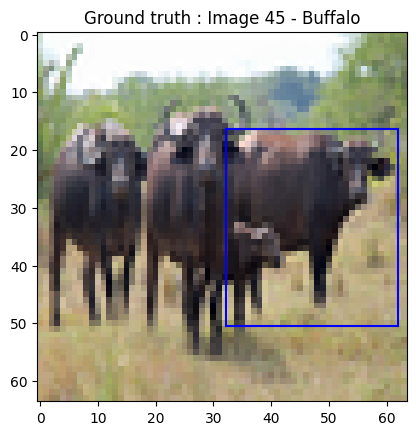

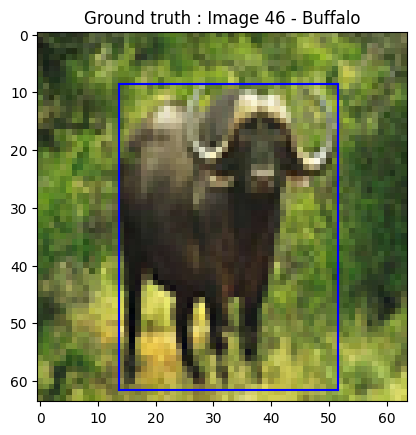

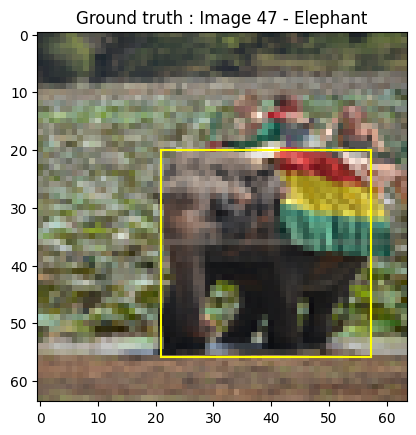

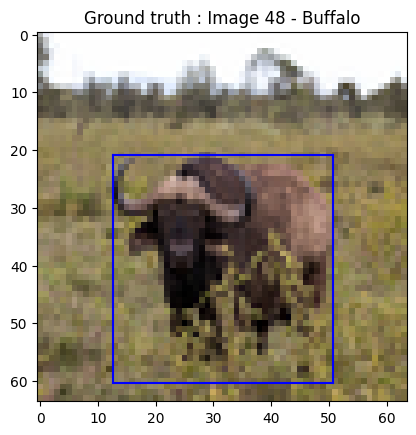

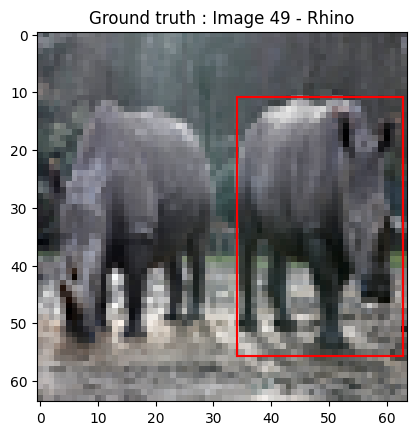

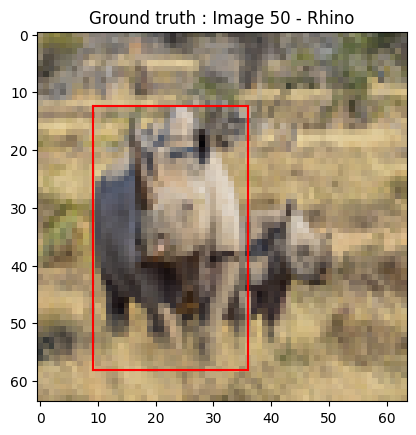

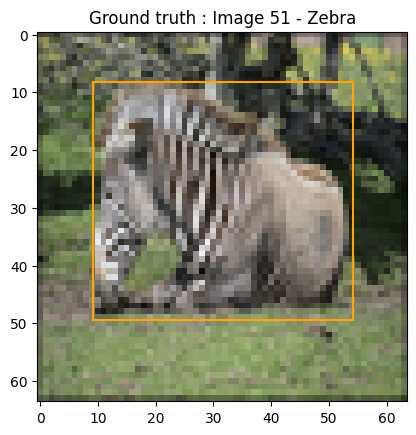

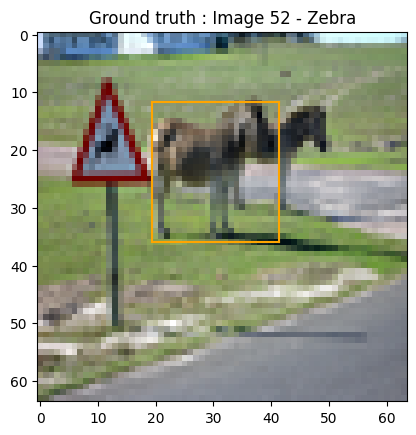

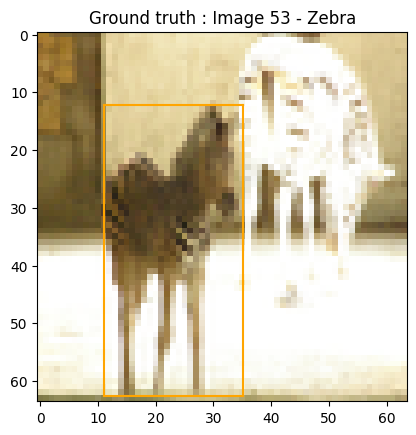

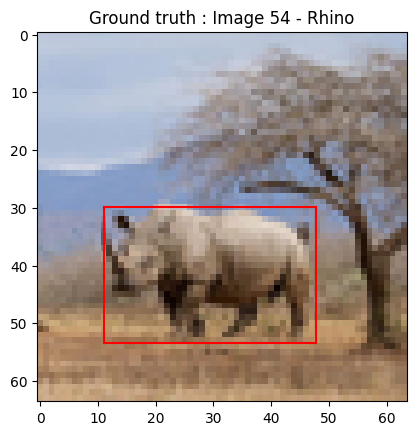

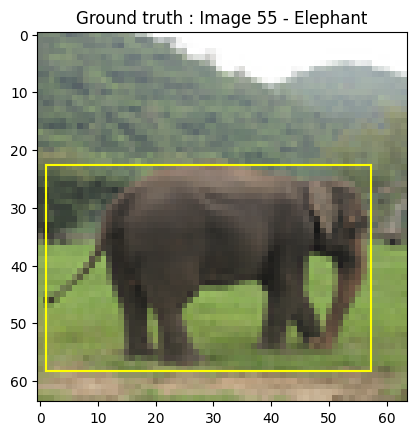

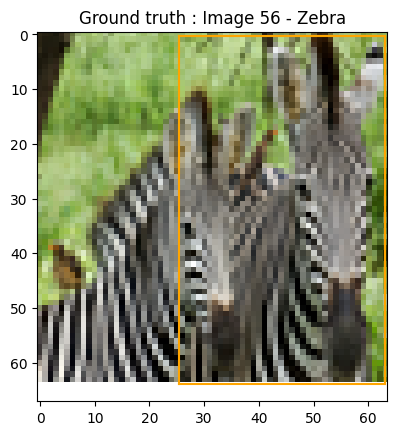

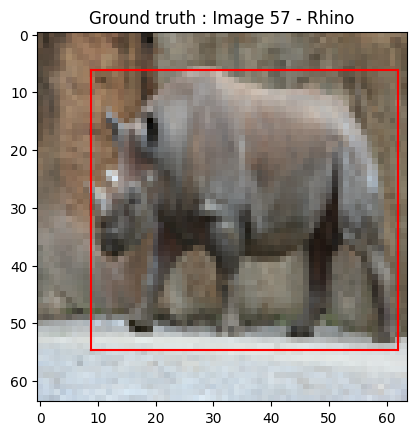

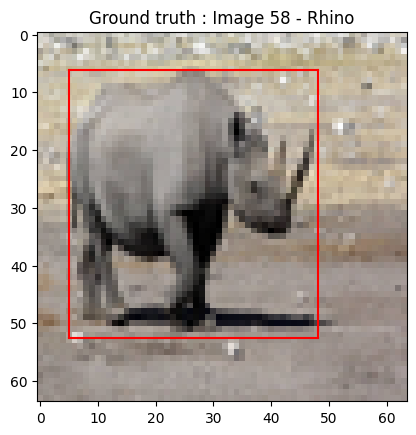

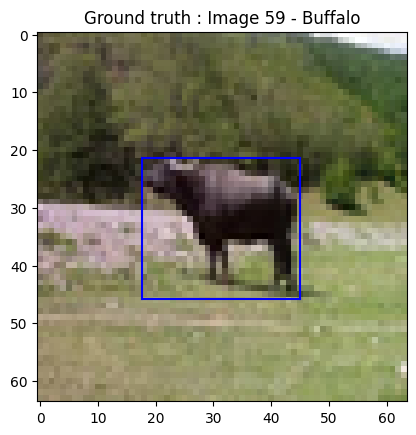

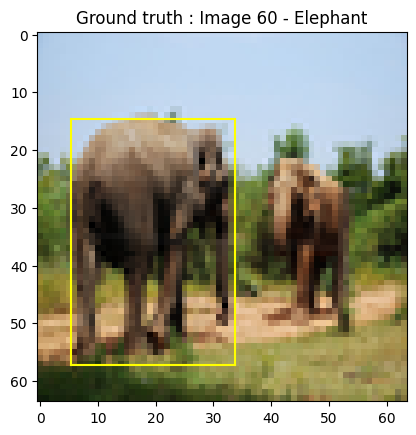

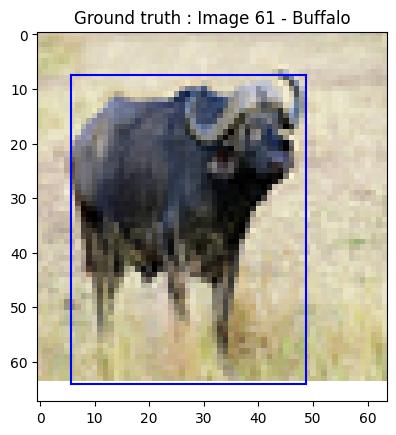

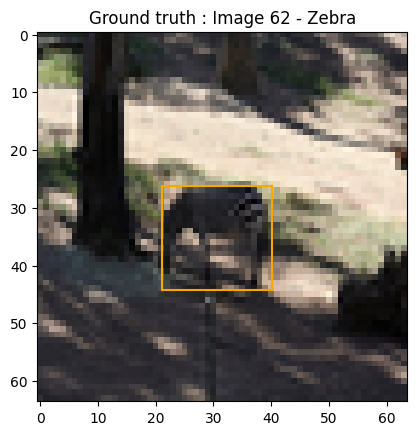

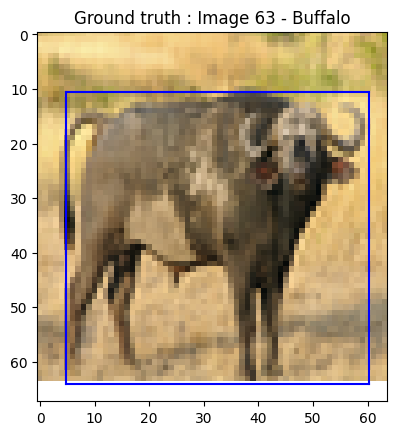

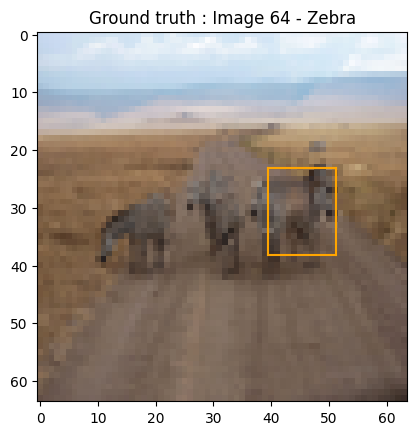

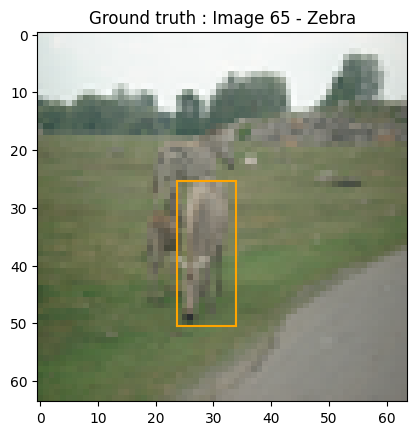

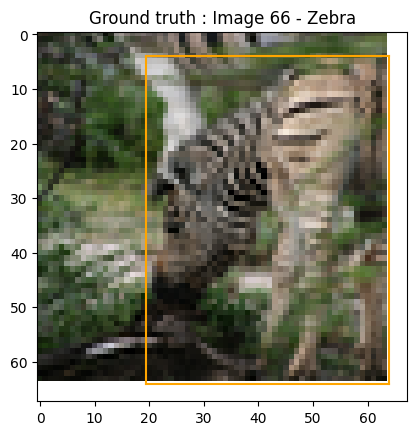

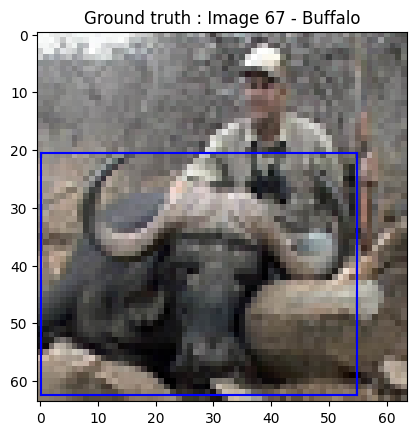

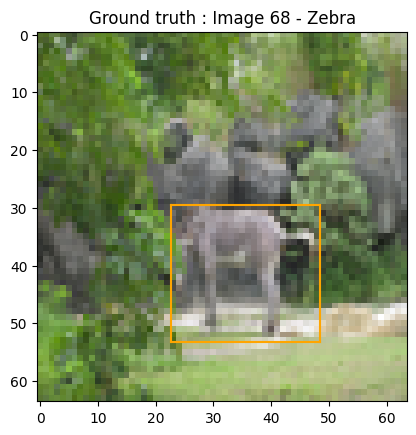

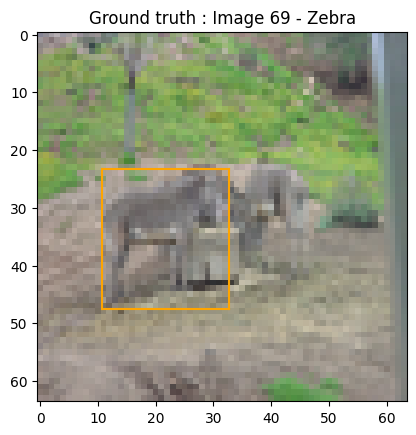

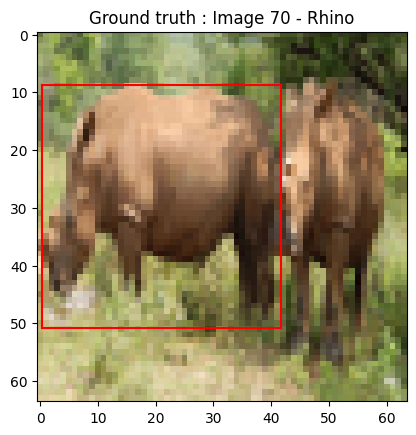

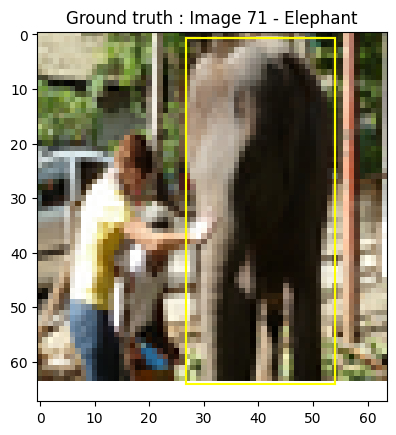

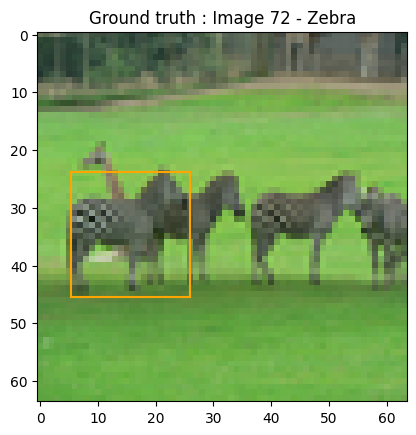

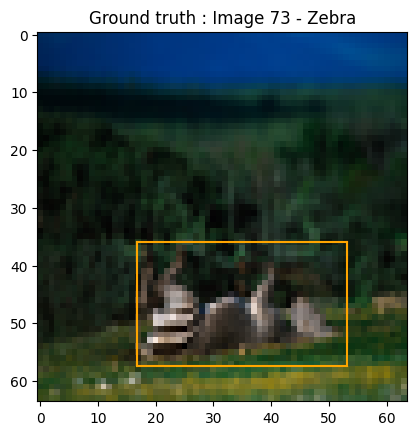

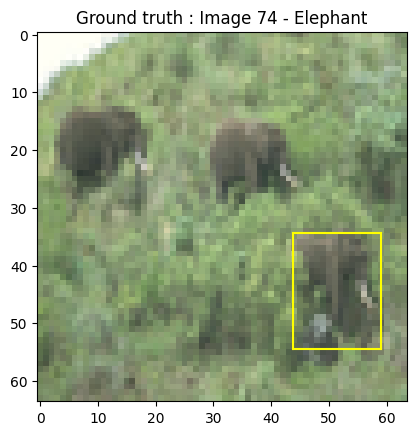

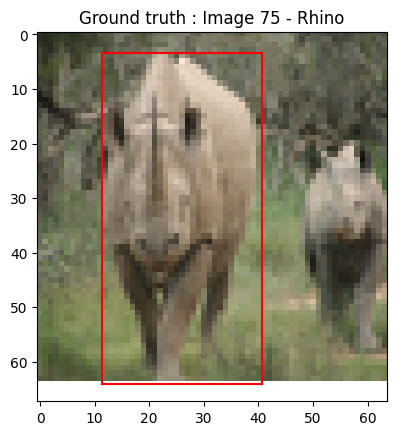

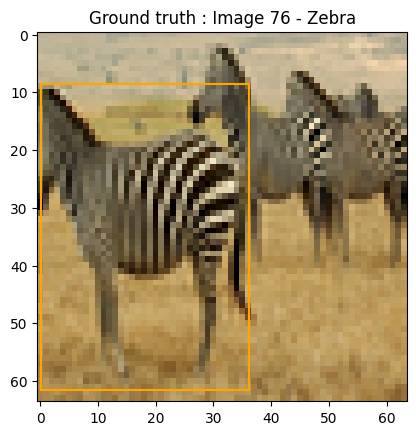

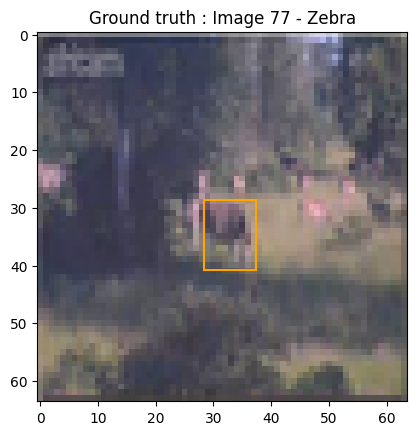

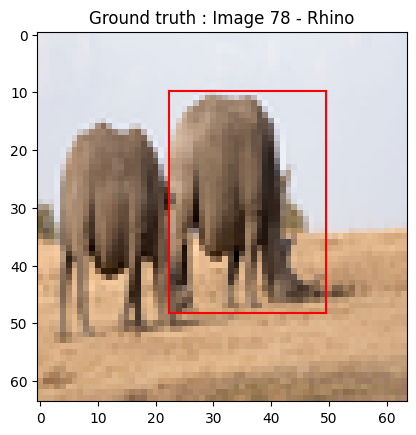

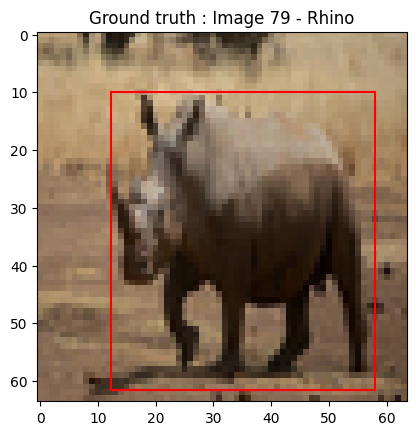

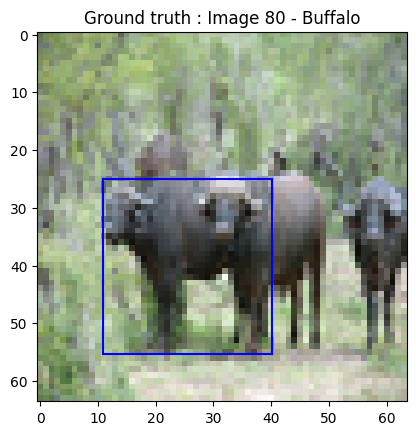

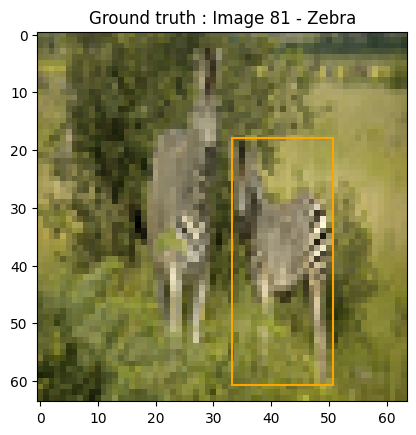

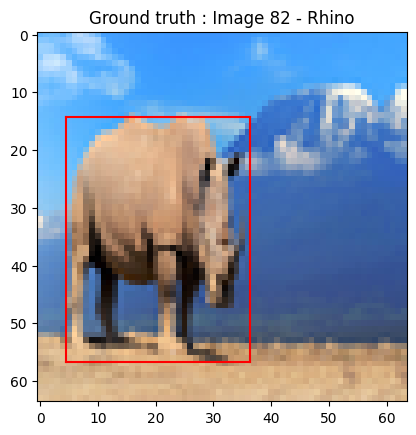

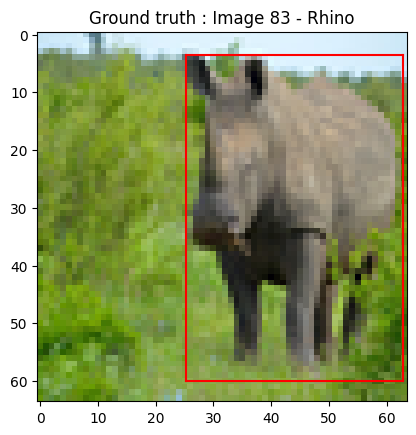

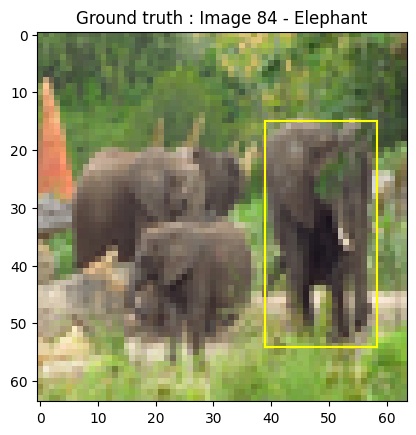

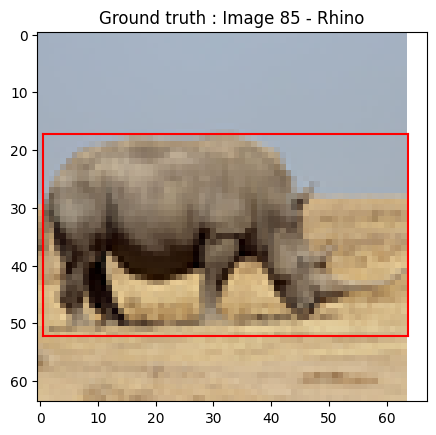

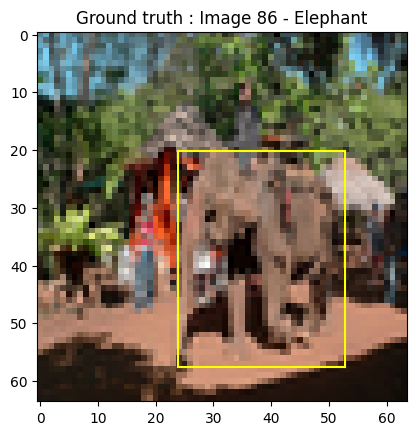

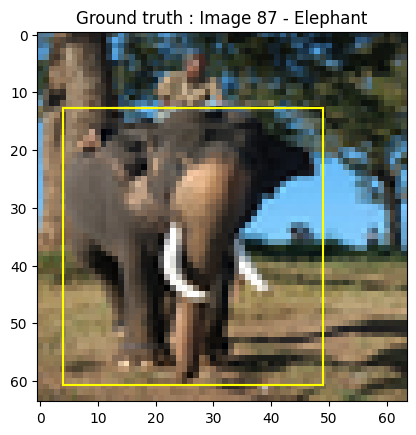

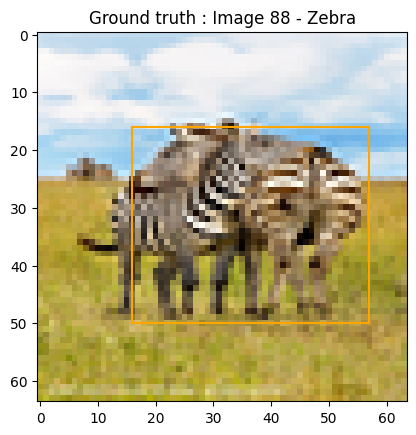

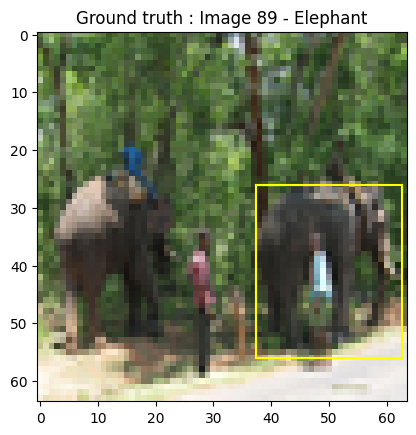

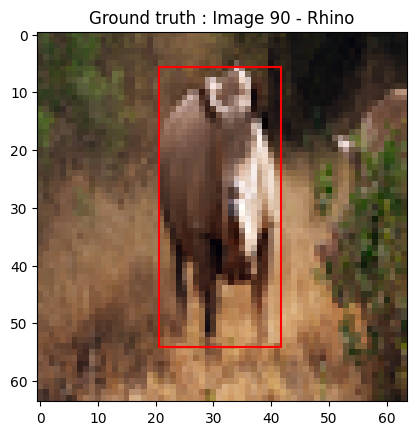

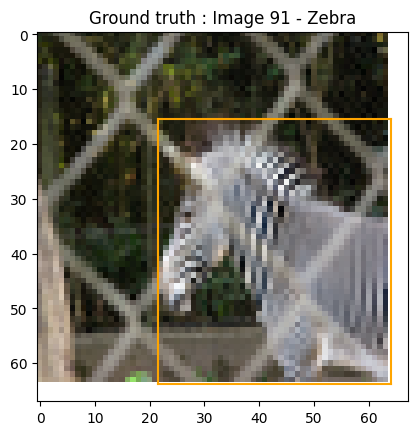

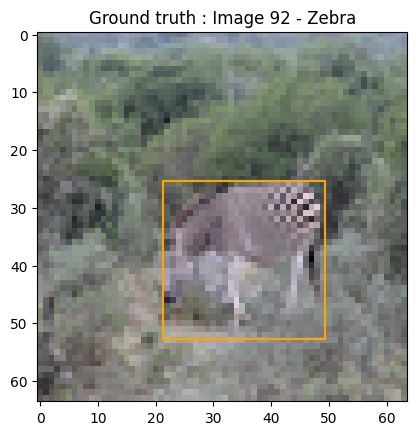

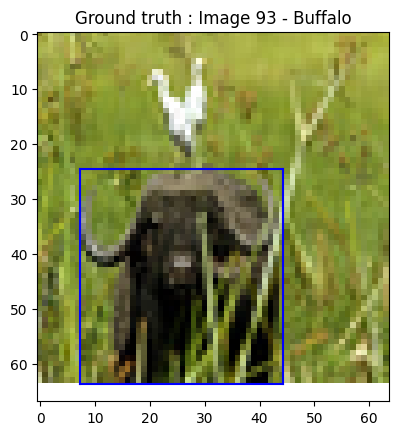

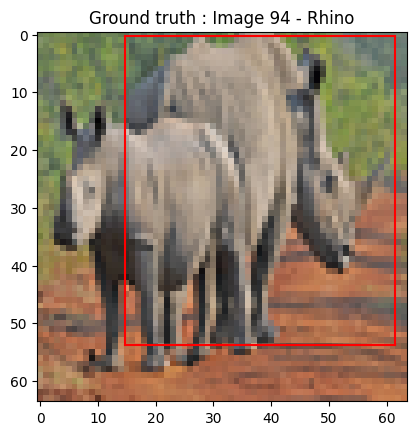

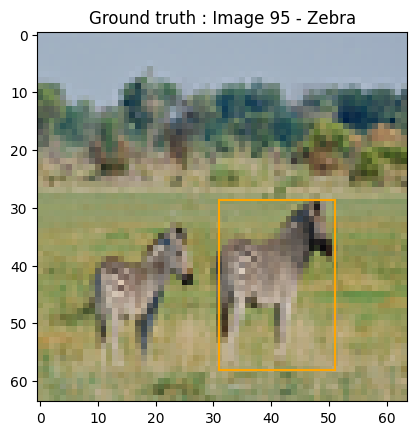

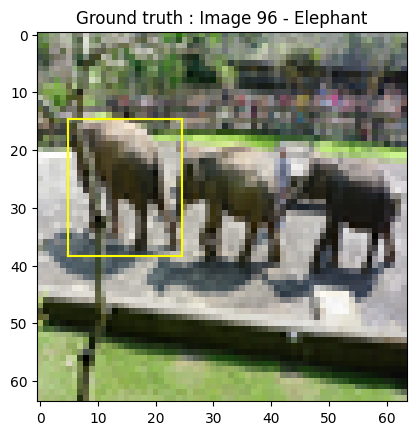

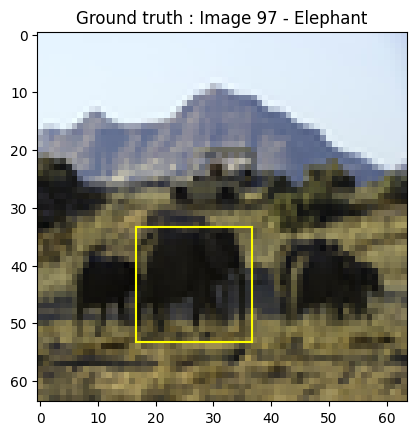

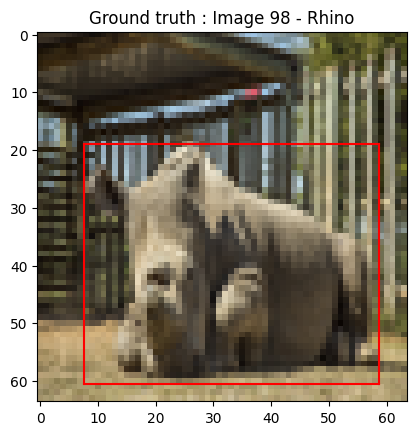

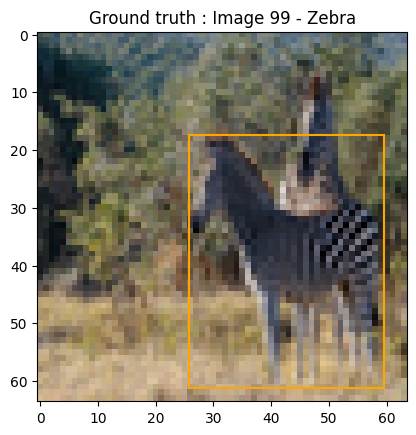

In [14]:
for i in range(100): #x.shape[0]):
    print_data_localization(x_train, y_train, image_size=IMAGE_SIZE, id=i)

## Useful functions

1 . Computation of the **IoU** coefficient (Intersection over Union) between real and predicted bounding boxes.

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [15]:
def compute_iou(y_true, y_pred):
    ### "Denormalization" of bounding box coordinates
    pred_box_xy = y_pred[:, 0:2] * y_std[0:2] + y_mean[0:2] ### TO BE COMPLETED ###
    true_box_xy = y_true[:, 0:2] * y_std[0:2] + y_mean[0:2] ### TO BE COMPLETED ###

    ### "Denormalization of the width and height of bounding boxes
    pred_box_wh = y_pred[:, 2:4] * y_std[2:4] + y_mean[2:4] ### TO BE COMPLETED ###
    true_box_wh = y_true[:, 2:4] * y_std[2:4] + y_mean[2:4] ### TO BE COMPLETED ###

    # Computation of the minimum and maximum coordinates of the real bounding box
    true_mins   = true_box_xy - true_box_wh/2 ### TO BE COMPLETED ###
    true_maxs   = true_box_xy + true_box_wh/2 ### TO BE COMPLETED ###

    # Computation of the minimum and maximum coordinates of the predicted bounding box
    pred_mins   = pred_box_xy - pred_box_wh/2 ### TO BE COMPLETED ###
    pred_maxs   = pred_box_xy + pred_box_wh/2 ### TO BE COMPLETED ###    

    # Determining the intersection of bounding boxes
    intersect_mins  = tf.maximum(pred_mins, true_mins)
    intersect_maxs  = tf.minimum(pred_maxs, true_maxs)
    intersect_wh    = tf.maximum(intersect_maxs - intersect_mins, 0.)
    intersect_areas = intersect_wh[:, 0] * intersect_wh[:, 1]

    # Area of predicted and actual bounding boxes
    true_areas = true_box_wh[:,0]*true_box_wh[:,1]
    pred_areas = pred_box_wh[:,0]*pred_box_wh[:,1]

    # Area of the union of predicted and real boxes
    union_areas = true_areas+pred_areas-intersect_areas ### TO BE COMPLETED ###

    iou_scores  = tf.truediv(intersect_areas, union_areas)
    return iou_scores

In [16]:
# %load solutions/compute_iou.py

In [17]:
def iou():
    def iou_metrics(y_true, y_pred):
        return compute_iou(y_true, y_pred)
    iou_metrics.__name__= "IoU"
    return iou_metrics

2. Visualization of learning quality

In [18]:
def plot_training_analysis(history, metric='loss'):    

    loss = history.history[metric]
    val_loss = history.history['val_' + metric]

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
    plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.legend()

    plt.show()

## A first example of CNN for object localization

This part aims to develop a first example of a convolutional network for object localization.

To do this, complete the codes provided to obtain a localization algorithm. You can use any convolutional base of your choice, but you must pay special attention to the output layer. Actually, you will produce three different outputs:
* one characterizing the presence of an object, 
* another providing the coordinates of the bounding box, and finally, 
* a last one performing the classification.

<center> <img src="https://drive.google.com/uc?id=14GsrBEwbb_zllj6UAJv43dy9BUkq1IG0" width=500></center>
<caption><center><b>Figure 3:</b> Illustration of the network architecture to be built.</center></caption>

<!-- <center> <img src="https://drive.google.com/uc?id=1bnh8zU7Os-w-5TT8hV4xDoThKQc-Ywc2" width=500></center>
<caption><center> Figure 4: Illustration des fonctions de coût à utiliser pour l'entraînement. </center></caption> -->

In [23]:
import tensorflow.keras.layers as kl
import tensorflow.keras.models as km
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [ ]:
def create_model_localization(input_shape=(64, 64, 3)):

    input_layer = Input(shape=input_shape)

    ### TO BE COMPLETED ###
    conv1 = Conv2D(32,3,activation)(input_layer)
    # Convolutions, Pooling, Dense,...  Up to you to form your network!
    # Your last layer must update a variable x, reused in the output layers below
    x = ...

    output_p     = Dense(..., activation=..., name='p')(x)       # Output characterizing the presence of an object
    output_coord = Dense(..., activation=..., name='coord')(x)   # Output characterizing bounding box coordinates
    output_class = Dense(..., activation=..., name='classes')(x) # Output characterizing the class probabilities

    output = [output_p, output_coord, output_class]
    model  = Model(input_layer, output)

    return model

In [25]:
# %load solutions/create_model_localization.py
def create_model_localization(input_shape=(64, 64, 3)):

    input_layer = Input(shape=input_shape)

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    x = Flatten()(pool4)

    output_p     = Dense(1, activation='sigmoid', name='p')(x)       # Output characterizing the presence of an object
    output_coord = Dense(4, activation='linear', name='coord')(x)    # Output characterizing bounding box coordinates
    output_class = Dense(4, activation='softmax', name='classes')(x) # Output characterizing the class probabilities

    output = [output_p, output_coord, output_class]
    model  = Model(input_layer, output)

    return model

You must associate a cost function with each network output to train your network. The total cost function will be the sum of the three previously defined cost functions, weighted by weights defined in the variable `loss_weights`.

**Take the time to test different values of** `loss_weights` **depending on the evolution of the metrics you observe during the training**.

In [26]:
from tensorflow.keras.optimizers import Adam

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [28]:
batch_size=16
model = create_model_localization()
opt   = Adam(learning_rate=3e-4)  

### TO BE COMPLETED ###
# Here put, in order, the cost functions associated with each output
loss=['binary_crossentropy', 'mse', 'categorical_crossentropy']

# We will associate a metric to each output: the accuracy for the two classifications,  
# and the IoU defined earlier for the quality of the bounding boxes. 
metrics=[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 1] ### Vary these WEIGHTS to find an ad hoc COMBINATION ###


model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )

history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:9]],
              epochs=30,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:9]]))

Epoch 1/30


2022-10-17 11:36:52.265696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-17 11:36:53.139737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-10-17 11:36:53.317749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


80/80 [==============================] - 7s 21ms/step - loss: 3.5748 - p_loss: 0.0702 - coord_loss: 2.0285 - classes_loss: 1.4761 - p_accuracy: 0.9962 - coord_IoU: 0.5205 - classes_accuracy: 0.2936 - val_loss: 2.2923 - val_p_loss: 0.0351 - val_coord_loss: 0.9459 - val_classes_loss: 1.3112 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.5848 - val_classes_accuracy: 0.4381
Epoch 2/30
80/80 [==============================] - 1s 14ms/step - loss: 2.1147 - p_loss: 0.0031 - coord_loss: 0.8840 - classes_loss: 1.2276 - p_accuracy: 1.0000 - coord_IoU: 0.5881 - classes_accuracy: 0.4453 - val_loss: 2.1312 - val_p_loss: 0.0147 - val_coord_loss: 0.8991 - val_classes_loss: 1.2174 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6089 - val_classes_accuracy: 0.4602
Epoch 3/30
80/80 [==============================] - 1s 14ms/step - loss: 1.8387 - p_loss: 0.0017 - coord_loss: 0.8108 - classes_loss: 1.0263 - p_accuracy: 1.0000 - coord_IoU: 0.6036 - classes_accuracy: 0.5819 - val_loss: 2.0214 - val_p_loss: 0.0055 

80/80 [==============================] - 1s 15ms/step - loss: 0.1915 - p_loss: 6.6266e-06 - coord_loss: 0.1579 - classes_loss: 0.0336 - p_accuracy: 1.0000 - coord_IoU: 0.7814 - classes_accuracy: 1.0000 - val_loss: 1.2538 - val_p_loss: 9.9667e-05 - val_coord_loss: 0.6399 - val_classes_loss: 0.6139 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6640 - val_classes_accuracy: 0.7699
Epoch 23/30
80/80 [==============================] - 1s 15ms/step - loss: 0.1725 - p_loss: 5.8872e-06 - coord_loss: 0.1469 - classes_loss: 0.0255 - p_accuracy: 1.0000 - coord_IoU: 0.7844 - classes_accuracy: 1.0000 - val_loss: 1.2828 - val_p_loss: 9.5393e-05 - val_coord_loss: 0.6299 - val_classes_loss: 0.6528 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6670 - val_classes_accuracy: 0.7478
Epoch 24/30
80/80 [==============================] - 1s 15ms/step - loss: 0.1646 - p_loss: 6.8886e-06 - coord_loss: 0.1394 - classes_loss: 0.0251 - p_accuracy: 1.0000 - coord_IoU: 0.7886 - classes_accuracy: 1.0000 - val_loss: 1.2441

In [ ]:
# %load solutions/train_model_localization.py

### Graphical validation

1. _Analysis of the results:_ Curves of the evolution of the loss function and of the IoU of the bounding boxes, as well as of the accuracy of the predicted classes

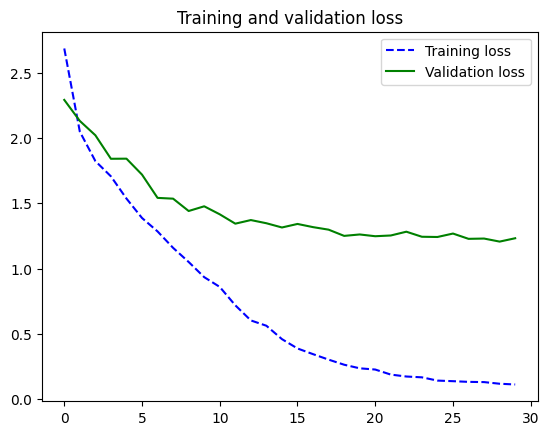

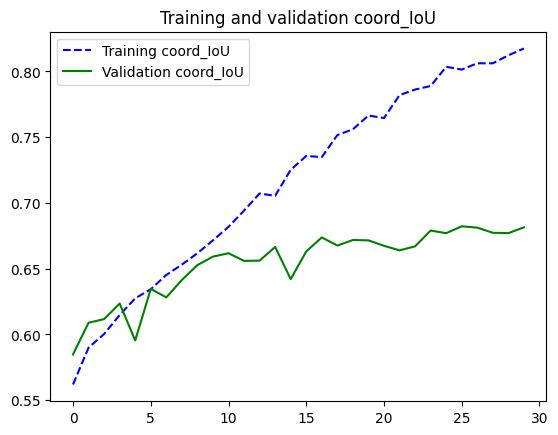

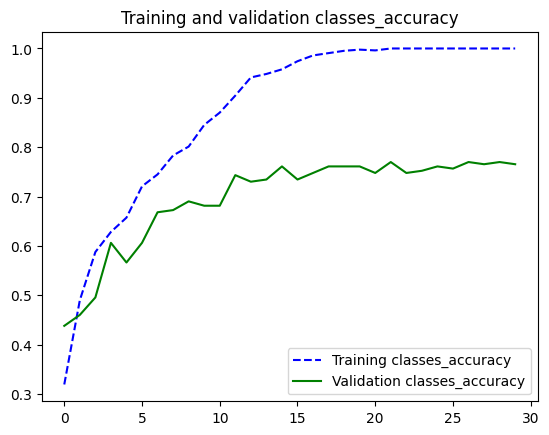

In [29]:
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

2. Prediction of validation data

In [30]:
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_val)
y_pred = np.zeros(y_val.shape)

for i in range(y_pred.shape[0]):
    y_pred[i, 0] = y_pred_presence[i]
    y_pred[i, 1:5] = y_pred_coords[i]
    y_pred[i, 5:9] = y_pred_classes[i]

3. Display of results on several images

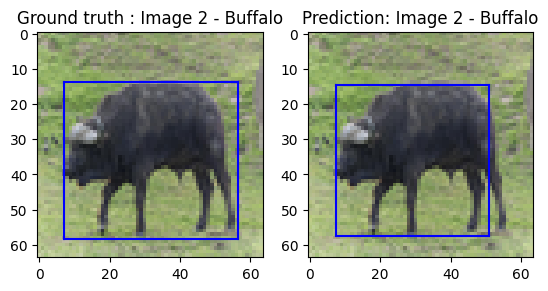

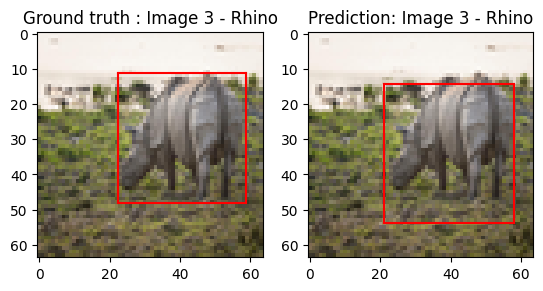

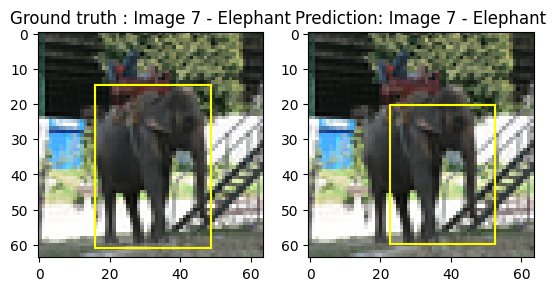

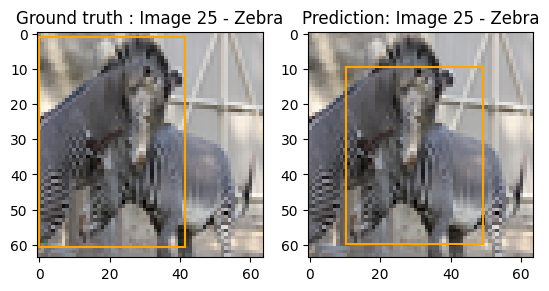

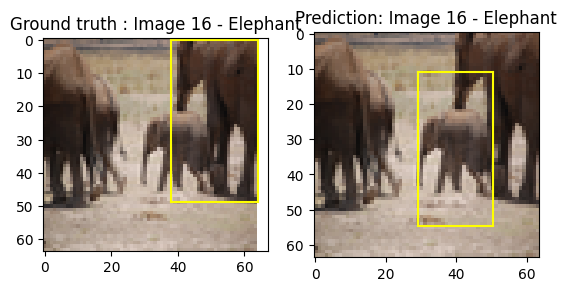

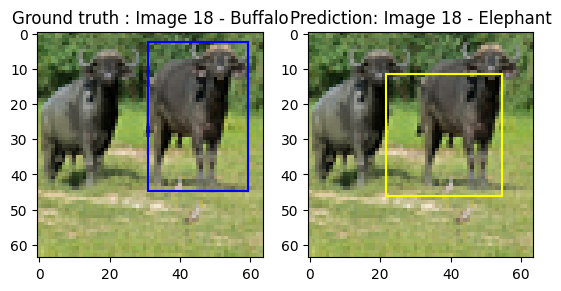

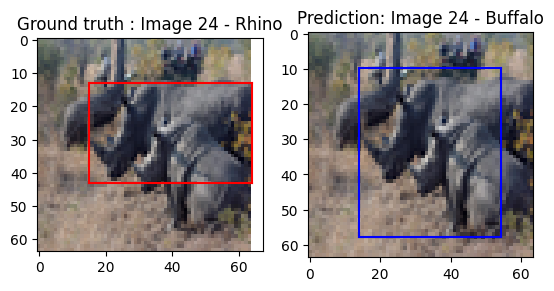

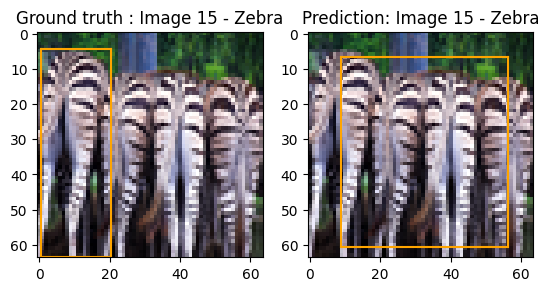

In [31]:
print_data_localization(x_val, y_val, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=25, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=16, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=18, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=24, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=15, image_size=IMAGE_SIZE)

## Improvement of the cost function

In practice, it is tricky to find a good combination of loss functions as you did on the previous cells. The cross-entropy and the mean square error give values that are too different from being combined effectively.

A variant, perhaps simpler to do work, is to use only the mean square error as the loss for all outputs. This variant is implemented in the YOLO algorithm, of which we will implement a variant in the second part of this tutorial. Test this solution below. As in the previous exercise, feel free to vary the weights of the different elements of the cost function.

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [36]:
batch_size=16
model = create_model_localization()
opt = Adam(learning_rate=3e-4)  

loss = ['mse', 'mse', 'mse']
metrics =[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1,2,3]


model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )

history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:9]],
              epochs=30,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:9]]))

Epoch 1/30
80/80 [==============================] - 2s 18ms/step - loss: 3.7981 - p_loss: 0.0571 - coord_loss: 1.5786 - classes_loss: 0.1946 - p_accuracy: 0.9385 - coord_IoU: 0.5268 - classes_accuracy: 0.2592 - val_loss: 2.4859 - val_p_loss: 0.0121 - val_coord_loss: 0.9591 - val_classes_loss: 0.1852 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.5928 - val_classes_accuracy: 0.3009
Epoch 2/30
80/80 [==============================] - 1s 14ms/step - loss: 2.2925 - p_loss: 6.4024e-04 - coord_loss: 0.8746 - classes_loss: 0.1809 - p_accuracy: 1.0000 - coord_IoU: 0.5960 - classes_accuracy: 0.3401 - val_loss: 2.3167 - val_p_loss: 0.0111 - val_coord_loss: 0.8886 - val_classes_loss: 0.1761 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.5926 - val_classes_accuracy: 0.4602
Epoch 3/30
80/80 [==============================] - 1s 15ms/step - loss: 2.0886 - p_loss: 0.0010 - coord_loss: 0.7930 - classes_loss: 0.1672 - p_accuracy: 1.0000 - coord_IoU: 0.6104 - classes_accuracy: 0.4749 - val_loss: 2.2597 - val_

80/80 [==============================] - 1s 15ms/step - loss: 0.2900 - p_loss: 3.5180e-06 - coord_loss: 0.1042 - classes_loss: 0.0272 - p_accuracy: 1.0000 - coord_IoU: 0.8083 - classes_accuracy: 0.9511 - val_loss: 1.5184 - val_p_loss: 7.3058e-05 - val_coord_loss: 0.6120 - val_classes_loss: 0.0981 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6730 - val_classes_accuracy: 0.7301
Epoch 23/30
80/80 [==============================] - 1s 15ms/step - loss: 0.2341 - p_loss: 5.4567e-06 - coord_loss: 0.0870 - classes_loss: 0.0200 - p_accuracy: 1.0000 - coord_IoU: 0.8329 - classes_accuracy: 0.9757 - val_loss: 1.5095 - val_p_loss: 6.2050e-05 - val_coord_loss: 0.6107 - val_classes_loss: 0.0960 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6779 - val_classes_accuracy: 0.7478
Epoch 24/30
80/80 [==============================] - 1s 15ms/step - loss: 0.2422 - p_loss: 3.9847e-06 - coord_loss: 0.0936 - classes_loss: 0.0183 - p_accuracy: 1.0000 - coord_IoU: 0.8211 - classes_accuracy: 0.9812 - val_loss: 1.4809

In [37]:
# %load solutions/train_model_localization_MSE.py

### Graphical validation

1. _Analysis of the results:_ Curves of the evolution of the loss function and of the IoU of the bounding boxes, as well as of the accuracy of the predicted classes

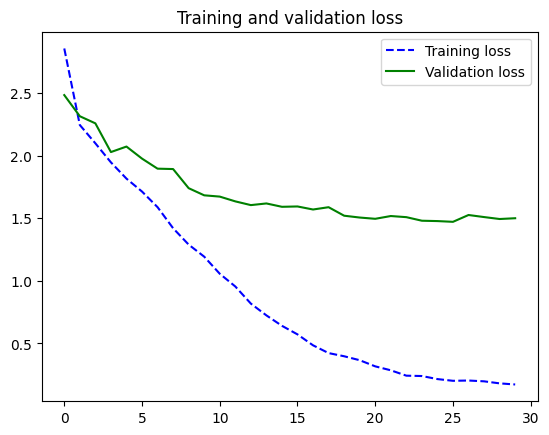

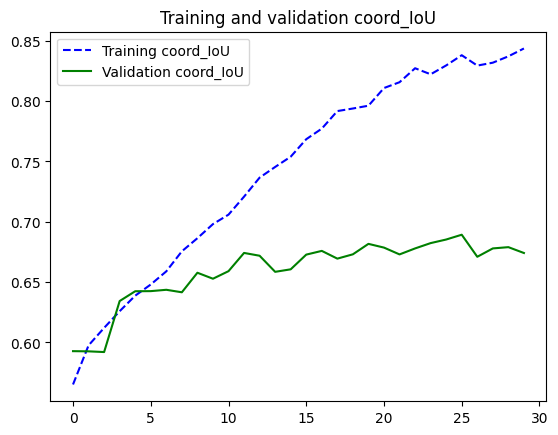

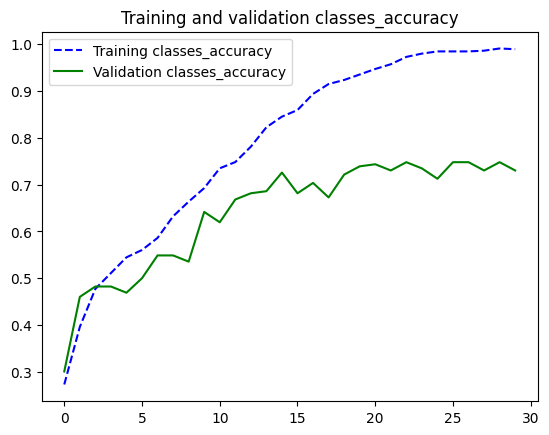

In [38]:
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

2. Prediction of validation data

In [39]:
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_val)
y_pred = np.zeros(y_val.shape)

for i in range(y_pred.shape[0]):
    y_pred[i, 0] = y_pred_presence[i]
    y_pred[i, 1:5] = y_pred_coords[i]
    y_pred[i, 5:9] = y_pred_classes[i]

3. Display of results on several images

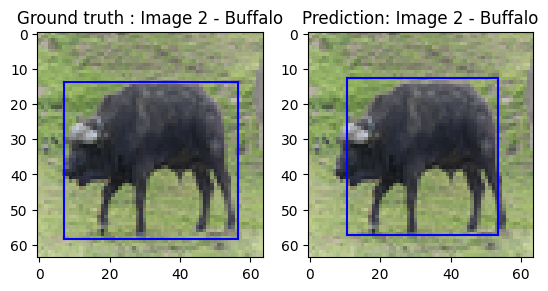

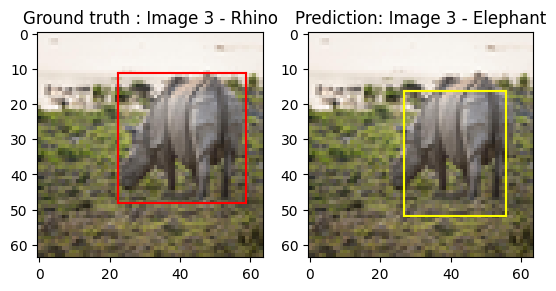

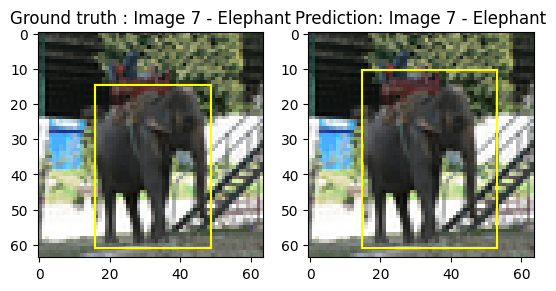

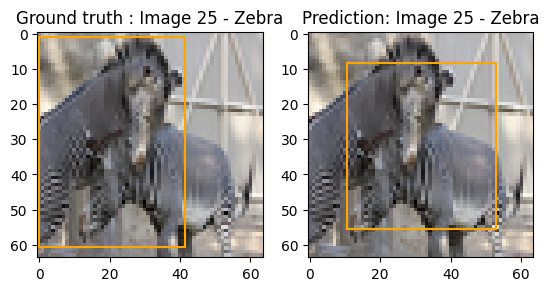

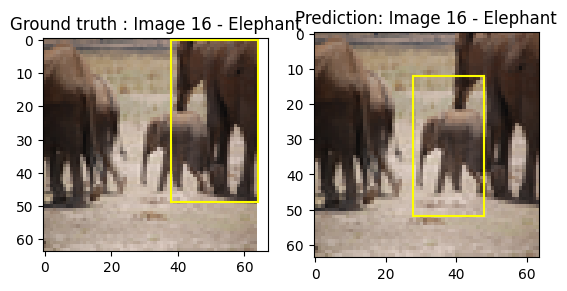

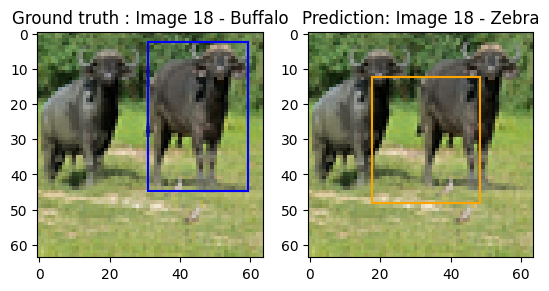

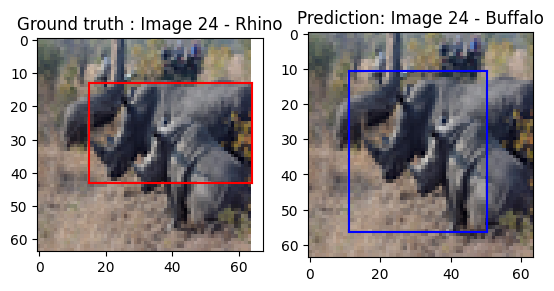

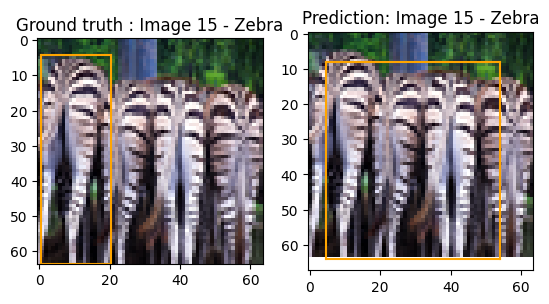

In [40]:
print_data_localization(x_val, y_val, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=25, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=16, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=18, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=24, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=15, image_size=IMAGE_SIZE)

### Some axes of improvement

Considering the small size of the database, the results are not bad! There is some confusion between some classes, but the predictions are often interesting.

However, there should still be strong overfitting at this stage. There are several possibilities to correct it: 
 
* _Regularization_ by weight decay, using `kernel_regularizer` on the network layers
* _Data augmentation_: For example, with a `Sequence`class and the use of the `Albumentation` library.
* Use of _transfer learning_: Starting from a network trained on *ImageNet* (which contains many classes of animals), we would benefit from very general filters which would help to limit overfitting. 

#### Transfer learning

In [41]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # The Dense part of the original network is not kept
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [42]:
def create_model_localization(input_shape=(64, 64, 3)):

    input_layer = Input(shape=input_shape)
    vgg = conv_base(input_layer)
    x = Flatten()(vgg)

    output_p = Dense(1, activation='sigmoid', name='p')(x)
    output_coord = Dense(4, activation='linear', name='coord')(x)
    output_class = Dense(4, activation='softmax', name='classes')(x)

    output= [output_p, output_coord, output_class]
    model = Model(input_layer, output)

    return model


model = create_model_localization()
conv_base.trainable = True
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 2, 2, 512)    14714688    input_6[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 2048)         0           vgg16[0][0]                      
__________________________________________________________________________________________________
p (Dense)                       (None, 1)            2049        flatten_4[0][0]                  
____________________________________________________________________________________________

In [43]:
batch_size=16
model = create_model_localization()
opt = Adam(learning_rate=3e-4)  

loss=['binary_crossentropy', 'mse', 'categorical_crossentropy']
metrics=[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 5, 1]


model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )

history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:9]],
              epochs=30,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:9]]))

Epoch 1/30
80/80 [==============================] - 5s 40ms/step - loss: 7.3035 - p_loss: 0.1997 - coord_loss: 1.1338 - classes_loss: 1.4347 - p_accuracy: 0.9509 - coord_IoU: 0.5508 - classes_accuracy: 0.2670 - val_loss: 5.6242 - val_p_loss: 0.0528 - val_coord_loss: 0.8421 - val_classes_loss: 1.3610 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6054 - val_classes_accuracy: 0.3142
Epoch 2/30
80/80 [==============================] - 2s 30ms/step - loss: 5.7898 - p_loss: 0.0420 - coord_loss: 0.8754 - classes_loss: 1.3707 - p_accuracy: 1.0000 - coord_IoU: 0.5874 - classes_accuracy: 0.2968 - val_loss: 5.1480 - val_p_loss: 0.0119 - val_coord_loss: 0.7589 - val_classes_loss: 1.3417 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.6585 - val_classes_accuracy: 0.3673
Epoch 3/30
80/80 [==============================] - 2s 31ms/step - loss: 4.6510 - p_loss: 0.0115 - coord_loss: 0.6622 - classes_loss: 1.3286 - p_accuracy: 1.0000 - coord_IoU: 0.6473 - classes_accuracy: 0.3631 - val_loss: 3.8605 - val_p_lo

80/80 [==============================] - 2s 30ms/step - loss: 0.0424 - p_loss: 3.4993e-05 - coord_loss: 0.0080 - classes_loss: 0.0025 - p_accuracy: 1.0000 - coord_IoU: 0.9408 - classes_accuracy: 1.0000 - val_loss: 2.3300 - val_p_loss: 3.7026e-05 - val_coord_loss: 0.3200 - val_classes_loss: 0.7301 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.7923 - val_classes_accuracy: 0.7876
Epoch 23/30
80/80 [==============================] - 2s 30ms/step - loss: 0.0337 - p_loss: 3.0303e-05 - coord_loss: 0.0064 - classes_loss: 0.0018 - p_accuracy: 1.0000 - coord_IoU: 0.9485 - classes_accuracy: 1.0000 - val_loss: 2.3611 - val_p_loss: 2.9029e-05 - val_coord_loss: 0.3345 - val_classes_loss: 0.6885 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.7925 - val_classes_accuracy: 0.8053
Epoch 24/30
80/80 [==============================] - 2s 30ms/step - loss: 0.0320 - p_loss: 2.6222e-05 - coord_loss: 0.0061 - classes_loss: 0.0017 - p_accuracy: 1.0000 - coord_IoU: 0.9457 - classes_accuracy: 1.0000 - val_loss: 2.3455

1. _Analysis of the results:_ Curves of the evolution of the loss function and of the IoU of the bounding boxes, as well as of the accuracy of the predicted classes

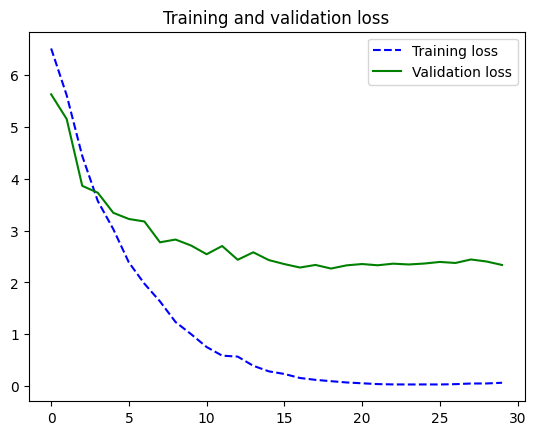

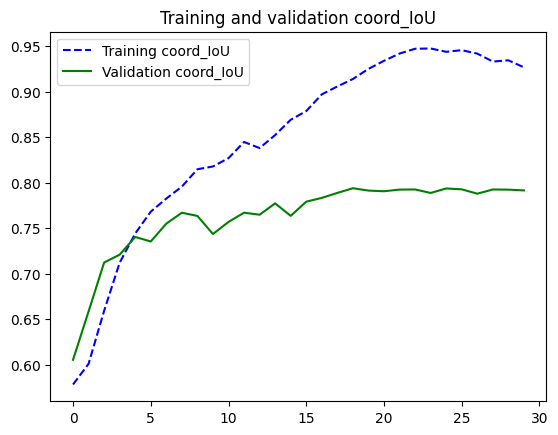

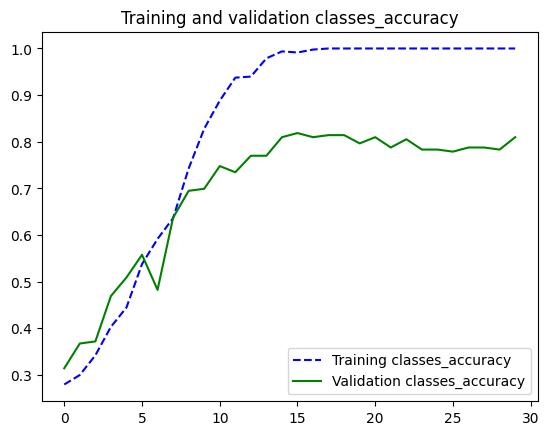

In [44]:
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

2. Prediction of validation data

In [45]:
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_val)
y_pred = np.zeros(y_val.shape)

for i in range(y_pred.shape[0]):
    y_pred[i, 0] = y_pred_presence[i]
    y_pred[i, 1:5] = y_pred_coords[i]
    y_pred[i, 5:9] = y_pred_classes[i]

3. Display of results on several images

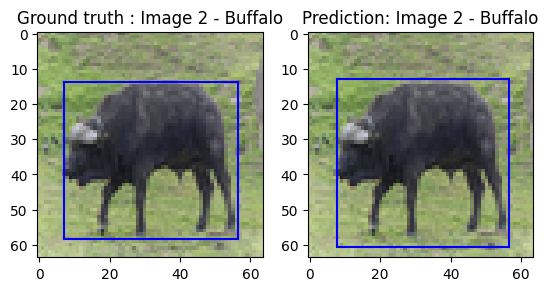

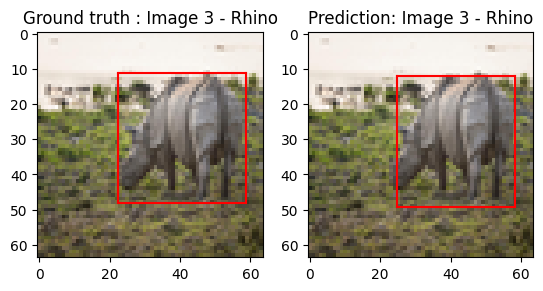

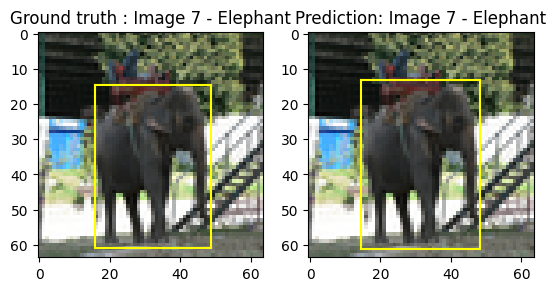

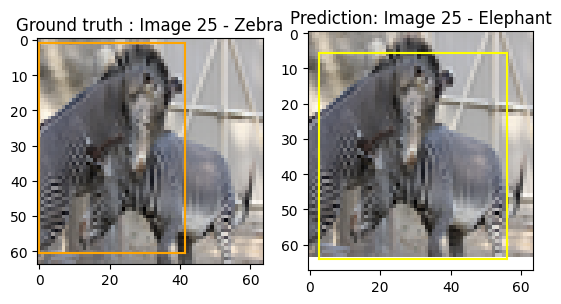

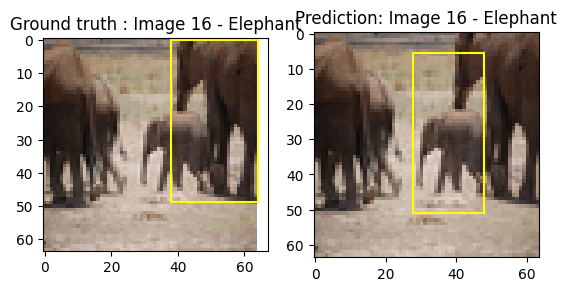

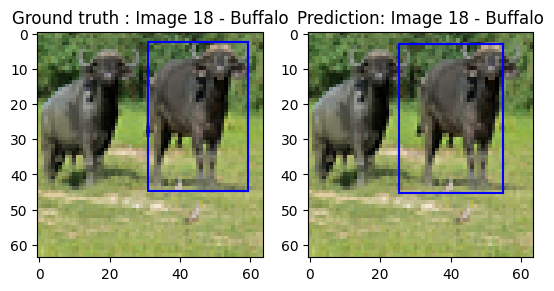

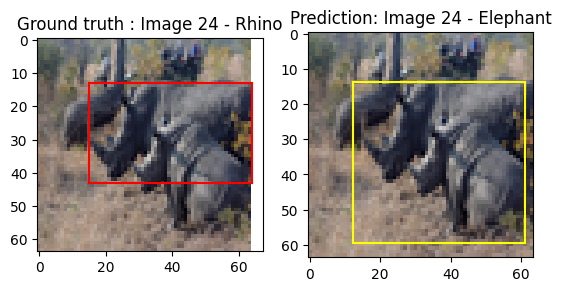

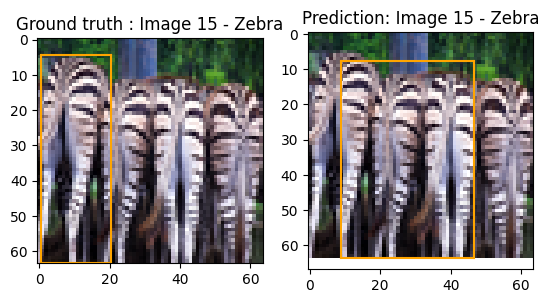

In [46]:
print_data_localization(x_val, y_val, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=25, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=16, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=18, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=24, image_size=IMAGE_SIZE)
print_data_localization(x_val, y_val, y_pred = y_pred, id=15, image_size=IMAGE_SIZE)

---
# PART II: Implementation of a simplified version of YOLO

In this part, we will try to go further by considering the more complex problem of object detection, _i.e._, the joint localization and classification of all the objects in the image; for that, we will implement a simplified version of YOLO.

The simplification comes from the fact that we will not include all the elements described in [Redmon](https://pjreddie.com/)'s article (for example, the optimizer's choice). One of the main simplifications is that _we will only consider one object per cell_.

<center> <img src="https://drive.google.com/uc?id=1V4aAS7K_Akj83apuMZ2vRjNvjgdgoOCh" width=500></center>
<caption><center><b>Figure 4</b>: Pipeline of the YOLO algorithm <a href="https://pjreddie.com/media/files/papers/yolo_1.pdf">[Redmon 2016]</a></center></caption>

As a reminder, the idea of YOLO is to slice the image into a grid of cells and perform a prediction of several bounding boxes as well as a classification per cell.

We use here the same dataset : the [Wildlife](https://drive.google.com/drive/folders/16EYaEPi4zfq96XWEtkqW7m2gVdpXORu6?usp=sharing) database.

## Useful functions

Definition of the different variables useful for the following.

In [47]:
IMAGE_SIZE = 64  # Size of the input images of the network
CELL_PER_DIM = 8 # Number of cells in width and height
BOX_PER_CELL = 1 # Number of objects per cell
NB_CLASSES = 4   # Number of classes of the problem
PIX_PER_CELL = IMAGE_SIZE/CELL_PER_DIM

DATASET_SIZE = 376*4

##### <span style="color:purple">**Question:** What is the size of the $y$-array in the YOLO framework?</span>

Size for a label $y$: SxSx

<span style="color:teal ">[Solution]</span>

<!-- $y$ is a vector of size $(S,S,N+5k)$, where:
* $S$ is the grid size, or with the notations introduced above `CELL_PER_DIM`,
* $N$ is the number of classes, _i.e._, `NB_CLASSES`, and
* $k$ is the number of objects detected per cell _i.e._ `BOX_PER_CELL`.

In other words, $y$ is of size (`CELL_PER_DIM`,`CELL_PER_DIM`,`NB_CLASSES`+5*`BOX_PER_CELL`). -->

### Data loading and formatting for the detection problem. 

The function defined hereafter is the pendant of the `load_data_detection` function previously defined.

Problem data (more than one bounding box per cell) are indicated and displayed during loading.

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [ ]:
def load_data_detection():
    # Path to the database
    ds_path = "./wildlife/"
    # Paths to the data of the 4 different classes
    paths = [ds_path+"buffalo/", ds_path+"elephant/", ds_path+"rhino/", ds_path+"zebra/"]
    # Index for adding data to the x and y variables 
    i = 0
    # Preparation of data structures for x and y
    x = np.zeros((DATASET_SIZE, ...)) ### TO BE COMPLETED ### 
    y = np.zeros((DATASET_SIZE, ...)) ### TO BE COMPLETED ### 

    # Save normalized bounding box width/height
    widths = []
    heights = []

    # Browse paths of each class
    for path in paths:

        # Browse the (sorted) files in the directory
        dirs = os.listdir(path)
        dirs.sort()

        for item in dirs:
            if os.path.isfile(path + item):
                # Extracting the file extension 
                extension = item.split(".")[1]

                if extension=="jpg" or extension=="JPG":
                    # Image : we will fill the variable x
                    # Reading the image
                    img = Image.open(path + item)
                    # Image scaling
                    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
                    # Filling the variable x
                    x[i] = np.asarray(img, dtype=np.int32)

                elif extension=="txt":
                    # Text file: bounding box coordinates to fill y
                    labels = open(path + item, "r")
                    # Retrieving of lines from the text file
                    labels = labels.read().split('\n')
                    # If the last line is empty, delete it 
                    if labels[-1]=="":
                        del labels[-1]

                    err_flag = 0
                    boxes = []
                    for label in labels:
                        # Retrieving information from the bounding box
                        label = label.split()
                        # Save width/height of bounding boxes
                        widths.append(float(...))  ### TO BE COMPLETED ### 
                        heights.append(float(...)) ### TO BE COMPLETED ### 
                        # Bounding box center coordinates in the image frame
                        cx, cy = float(...) * IMAGE_SIZE, float(...) * IMAGE_SIZE ### TO BE COMPLETED (x2) ### 
                        # Determination of the indices of the cell in which the center falls
                        ind_x, ind_y = int(cx // PIX_PER_CELL), int(cy // PIX_PER_CELL)
                        # YOLO : "The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell."
                        # -> Compute the coordinates of the center relative to the cell in which it is located
                        cx_cell = (cx - ind_x * PIX_PER_CELL) / PIX_PER_CELL
                        cy_cell = (cy - ind_y * PIX_PER_CELL) / PIX_PER_CELL
                        # Confidence index of the bounding box
                        presence = np.array(...) ### TO BE COMPLETED ### 
                        # "One-hot vector " to represent the class probabilities
                        classes = ... ### TO BE COMPLETED ### 
                        # We arrange the class probabilities at the end of the vector ([ BOX 1 ; BOX 2 ; ... ; BOX N ; CLASSES])
                        y[i, ind_x, ind_y, 5 * BOX_PER_CELL:] = classes

                        boxes.append([cx, cy, label[3]*IMAGE_SIZE, label[4]*IMAGE_SIZE])
                        # Determining the cell bounding box index in which to store the information
                        ind_box = 0
                        while y[i, ind_x, ind_y, 5*ind_box] == 1 and ind_box < BOX_PER_CELL - 1:
                            # If the current index box is already in use (presence = 1)  
                            # and the maximum number of boxes has not been reached, we go to the next box
                            ind_box = ind_box + 1

                        if y[i, ind_x, ind_y, 5*ind_box] == 1:
                            print("ERROR: THE CELL ALREADY CONTAINS ALL THE AVAILABLE BOXES")
                            print(path + item)
                            err_flag = 1
                        else:
                            y[i, ind_x, ind_y, 5*ind_box] = 1
                            y[i, ind_x, ind_y, 5*ind_box + 1] = cx_cell
                            y[i, ind_x, ind_y, 5*ind_box + 2] = cy_cell
                            # Square root of the width and height of the box
                            y[i, ind_x, ind_y, 5*ind_box + 3] = math.sqrt(float(...)) ### TO BE COMPLETED : width ### 
                            y[i, ind_x, ind_y, 5*ind_box + 4] = math.sqrt(float(...)) ### TO BE COMPLETED : height ### 

                    i = i + 1
                    if err_flag == 1:
                        img_name = item.split(".")[0]
                        img = Image.open(path + img_name + '.jpg')
                        # Image scaling
                        img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)

                        plt.imshow(img)
                        for ind_cell in range(CELL_PER_DIM):                
                            plt.plot([ind_cell*PIX_PER_CELL, ind_cell*PIX_PER_CELL], [0, IMAGE_SIZE-1], 'k-')
                            plt.plot([0, IMAGE_SIZE-1], [ind_cell*PIX_PER_CELL, ind_cell*PIX_PER_CELL], 'k-')

                        for ind_box_plot in range(len(boxes)):
                            box = boxes[ind_box_plot]
                            plt.plot(box[0], box[1], 'b.')
                        plt.show()

                else:
                    print("extension found: ", extension)

    return x, y, widths, heights

In [ ]:
# %load solutions/load_data_detection.py

In [ ]:
x, y, w, h = load_data_detection()

As before, the database is divided between training and validation data

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Image normalization
x_train = x_train/255
x_val = x_val/255

x_train.shape, y_train.shape, x_val.shape, y_val.shape

### Display of data and detection results

In [ ]:
from scipy.special import softmax

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [ ]:
def print_data_detection(x, y, id=None, image_size=IMAGE_SIZE, mode='gt'):
    if id==None:
        # Random drawing of an image in the database
        num_img = np.random.randint(x.shape[0]) 
        print(num_img)
    else:
        num_img = id

    img = x[num_img]
    lab = y[num_img]

    colors = ["blue", "yellow", "red", "orange"] # Different colors for the different classes
    classes = ["Buffalo", "Elephant", "Rhino", "Zebra"]

    boxes = lab[:, :, 1:5]
    for ind_x in range(CELL_PER_DIM):
        for ind_y in range(CELL_PER_DIM):
            box = boxes[ind_x, ind_y]
            box[0] = ... ### TO BE COMPLETED ### 
            box[1] = ... ### TO BE COMPLETED ### 
            box[2] = box[2]**2 * IMAGE_SIZE
            box[3] = box[3]**2 * IMAGE_SIZE
            boxes[ind_x, ind_y] = box

    # Retrieve all information from bounding boxes
    all_presences = np.reshape(lab[:, :, 0], (CELL_PER_DIM*CELL_PER_DIM))
    all_boxes = np.reshape(lab[:, :, 1:5], (-1, 4))
    all_classes = np.reshape(lab[:, :, 5:9], (-1, 4))

    if mode=='pred':
        all_presences = 1 / (1 + np.exp(-all_presences))
        all_classes = softmax(all_classes, axis=1)

    indices_sorted = np.argsort(-all_presences)

    # Eliminate all bounding boxes whose probability of presence is < threshold 
    threshold = 0.35
    all_boxes = ... ### TO BE COMPLETED ### 
    all_classes = ... ### TO BE COMPLETED ### 
    all_presences = ... ### TO BE COMPLETED ### 


    # Image display
    plt.imshow(img)
    for i in range(all_boxes.shape[0]):

        # Determination of the class
        class_id = ... ### TO BE COMPLETED ###
        lab = all_boxes[i]
        # Determination of the extrema of the bounding box
        p_x = [..., ...] ### TO BE COMPLETED ###
        p_y = [..., ...] ### TO BE COMPLETED ###
        # Display the bounding box in the right color
        [...] ### TO BE COMPLETED ###
  
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()  

In [ ]:
# %load solutions/print_data_detection.py

In [ ]:
print_data_detection(x_train, y_train, image_size=IMAGE_SIZE)

## A simplified version of YOLO

The model proposed below is only one possibility among many others. The Redmon article mentions a delicate instability during the training. So, we chose to use an elu (exponential linear unit) activation function.

<center> <img src="https://drive.google.com/uc?id=17_-sM2a1rMxvdkhd8FiQCX4pSt0EBuNC" width=500></center>
<caption><center><b>Figure 5</b>: YOLO output layer</a></center></caption>

In [ ]:
from keras import regularizers

##### <span style="color:purple">**Todo:** Complete the last layer to have the right size output.</span>



In [ ]:
def create_model_YOLO(input_shape=(64, 64, 3)):
    weight_decay = 0

    input_layer = Input(shape=input_shape)

    conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    dense4 = Flatten()(pool3)
    dense4 = Dense(512, activation='elu',kernel_regularizer=regularizers.l2(weight_decay))(dense4)
    dense5 = Dense(512, activation='elu',kernel_regularizer=regularizers.l2(weight_decay))(dense4)
    output = Dense(..., activation='linear',kernel_regularizer=regularizers.l2(weight_decay))(dense5) ### TO BE COMPLETED ###
    output = Reshape((...))(output) ### TO BE COMPLETED ###

    model = Model(input_layer, output)

    return model

In [ ]:
# %load solutions/create_model_YOLO.py

In [ ]:
model = create_model_YOLO()
model.summary()

### Cost function

We now come to the tricky part of the YOLO implementation: the definition of the cost function to use.

<center> <img src="https://drive.google.com/uc?id=1CM4EJks6Tz-6uBK6EwUmQkuhe8ef6o5A" style="width:500;height:300px;"></center>
<caption><center> Detail of the loss function defined in the YOLO v1 article</center></caption>

When writing a custom cost function in `keras`, it is necessary to use only the functions on the following page: https://keras.rstudio.com/articles/backend.html. 
Indeed this cost function, which will be called during the training, will treat tensors, not `numpy` arrays. We must therefore use the `tensorflow` library, which allows us to manipulate tensors.

An essential part of the function is already written: the one that allows the separation of the data of the so-called "empty" cells (the ground truth does not contain a bounding box) from the "non-empty" ones.

The details of the cost function are shown above: in the article $\lambda_{\text{coord}} = 5$ and $\lambda_{\text{noobj}} = 0.5$. 
* The $x_i$, $y_i$, $w_i$, and $h_i$ correspond to the coordinates of a bounding box; 
* $C_i$ corresponds to the probability of the presence of an object in the cell (sigmoid function applied to the corresponding output elements); and 
* the $p_i(c)$ are the class probabilities (softmax function applied to the corresponding output elements).

In [ ]:
from keras import backend as K
from keras.layers import Reshape, Input

##### <span style="color:purple">**Todo:** Complete the following function</span>

In [ ]:
# Definition of the YOLO loss function
def YOLOss(lambda_coord, lambda_noobj, batch_size):

    # "Green" part: subpart concerning the confidence index 
    # and the class probabilities probabilities in the case where a box is present in the cell
    def box_loss(y_true, y_pred):
        return ... ### TO BE COMPLETED ###

    # "Blue" part: subpart concerning the coordinates of the bounding box in the case where a box is present in the cell
    def coord_loss(y_true, y_pred):
        return ... ### TO BE COMPLETED ###


    # "Red" part: subpart concerning the confidence index in case no box is present in the cell
    def nobox_loss(y_true, y_pred):
        return ... ### TO BE COMPLETED ###


    def YOLO_loss(y_true, y_pred):

        # Reshape the tensors from bs x S x S x (5B+C) to (bsxSxS) x (5B+C)
        y_true = K.reshape(y_true, shape=(-1, 9))
        y_pred = K.reshape(y_pred, shape=(-1, 9))

        # Search (in y_true labels) for indices of cells for which at least the first bounding box is present
        not_empty = K.greater_equal(y_true[:, 0], 1)      
        indices = K.arange(0, K.shape(y_true)[0])
        indices_notempty_cells = indices[not_empty]

        empty = K.less_equal(y_true[:, 0], 0)
        indices_empty_cells = indices[empty]

        # Separate the cells of y_true and y_pred with or without bounding box
        y_true_notempty = K.gather(y_true, indices_notempty_cells)
        y_pred_notempty = K.gather(y_pred, indices_notempty_cells)

        y_true_empty = K.gather(y_true, indices_empty_cells)
        y_pred_empty = K.gather(y_pred, indices_empty_cells)

        return (box_loss(y_true_notempty, y_pred_notempty) + lambda_coord*coord_loss(y_true_notempty, y_pred_notempty) + lambda_noobj*nobox_loss(y_true_empty, y_pred_empty))/batch_size

   
    # Return a function
    return YOLO_loss

In [ ]:
# %load solutions/YOLOss.py

### Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=16
model = create_model_YOLO()
opt = Adam(learning_rate=1e-4)  


# As the training is unstable, we trigger a model backup each time the validation loss reaches a new minimum
model_saver = ModelCheckpoint('tmp/best_weights', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')


loss=[YOLOss(5, 0.5, batch_size)]

model.compile(loss=loss,
              optimizer=opt)

history = model.fit(x_train, y_train,
              epochs=100,
              batch_size=batch_size,           
              validation_data=(x_val, y_val),
              callbacks = [model_saver])

1. Test of the version at the end of the training

In [ ]:
y_pred = model.predict(x_train)
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE, mode='pred')

In [ ]:
y_pred = model.predict(x_val)
print_data_detection(x_val, y_pred, image_size=IMAGE_SIZE, mode='pred')

2. Test the _best_ saved version

In [ ]:
model.load_weights('tmp/best_weights')

In [ ]:
y_pred = model.predict(x_train)
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE, mode='pred')

In [ ]:
y_pred = model.predict(x_val)
print_data_detection(x_val, y_pred, image_size=IMAGE_SIZE, mode='pred')

### Loading weights from an already trained network

As YOLO training is very unstable, it is possible that at the end of this tutorial you will not get very convincing results. To finish this tutorial, you will find below the weights of a model trained for a long time.

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1q9PW6VwiVhS2MgRHdN9BlxXZxm2dgnTv' -O best_weights.index
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1_mtwH4W4vRf-5yGRFjHZHiGzJDr9cYBb' -O best_weights.data-00000-of-00001

In [ ]:
model.load_weights('best_weights')

In [ ]:
y_pred = model.predict(x_train)
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE, mode='pred')

In [ ]:
y_pred = model.predict(x_val)
print_data_detection(x_val, y_pred, image_size=IMAGE_SIZE, mode='pred')

The results are not perfect, but we are starting to see some good results. As previously, we could limit  overfitting by using data augmentation in this training. 

We can already see in the few examples below that some of the images are rather well-predicted.

In [ ]:
y_pred = model.predict(x_val)

print_data_detection(x_val, y_pred, id=81,  image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=28,  image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=37,  image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=220, image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=214, image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=193, image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=39,  image_size=IMAGE_SIZE, mode='pred')
print_data_detection(x_val, y_pred, id=108, image_size=IMAGE_SIZE, mode='pred')